# Предсказание развития пандемии (май 2020)

## 0. Введение

Проблемой короновируса COVID-19 буквально сейчас заняты многие ученые по всему миру. В стороне не осталось и комьюнити Data scientist-ов, которые пытаются не просто предсказать развитие пандемии, а помочь определить наиболее значимые факторы, влияющие на распространение заразы. Например на небезызвестном [Kaggle](https://www.kaggle.com/tags/covid19).

В небольшом исследовании я буду использовать ежедневно обновляемые данные из [репозитория](https://github.com/datasets/covid-19), а конкретно [time-series-19-covid-combined.csv](https://github.com/datasets/covid-19/blob/master/data/time-series-19-covid-combined.csv).

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sma
import statsmodels.formula.api as smfa
import statsmodels.tsa.stattools as smstt
%matplotlib inline

pd.options.display.float_format = '{:.2f}'.format

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 15)

In [ ]:
df = pd.read_csv('time-series-19-covid-combined.csv')
df.head()

Date Country/Region Province/State  ...  Confirmed  Recovered  Deaths
0  2020-01-22    Afghanistan            NaN  ...       0.00       0.00    0.00
1  2020-01-23    Afghanistan            NaN  ...       0.00       0.00    0.00
2  2020-01-24    Afghanistan            NaN  ...       0.00       0.00    0.00
3  2020-01-25    Afghanistan            NaN  ...       0.00       0.00    0.00
4  2020-01-26    Afghanistan            NaN  ...       0.00       0.00    0.00

[5 rows x 8 columns]

## 1. Exploratory data analysis

#### 1.1 Определим границы исследуемого периода, количество заболевших, погибших, выздоровивших. Отобразим на карте распространение болезни.

In [ ]:
date_start = df.Date[0]
date_now = list(df.Date)[-1]
print('Коронавирус COVID19 начался  {} '.format(date_start))
print('Исследуемый период вируса заканчивается сегодня  {} '.format(date_now))

#Для того чтобы правильно указать количество заболевших, умерших и выздоровивших, необходимо для начала понять, какие данные у нас в датасете
print(df.describe())
#Из значений max следует, что данные в столбцах – кумулятивные. То есть в каждый день дается итог с накоплением. 

#теперь определим количество заболевших, погибших, выздровивших за исследуемый период
num_confirmed = df.loc[df['Date'] == list(df.Date)[-1]].Confirmed.sum()
num_recovered = df.loc[df['Date'] == list(df.Date)[-1]].Recovered.sum()
num_deaths = df.loc[df['Date'] == list(df.Date)[-1]].Deaths.sum()
print('На данный момент количество заболевших составляет {} '.format(num_confirmed))
print('Количество погибших от коронавируса составляет {} '.format(num_deaths))
print('Количество выздоровивших составляет  {} '.format(num_recovered))

#теперь покажем распространение болезни на конец исследуемого периода (на 23.04.2020) (будем предполагать, что необходимо посчитать число Confirmed)
#воспользуемся для этого библиотекой plotly
df_last = df.loc[df['Date'] == list(df.Date)[-1]]

df_last['Date'] = pd.to_datetime(df_last['Date'])
df_last['month'] = df_last['Date'].dt.month
df_last.head()

df_last['Confirmed'] = df_last['Confirmed'].replace(-1, 0.00)
nan = df_last['Confirmed'].fillna(0.00)

df_last['Confirmed'] = nan
import plotly.express as px
fig = px.scatter_geo(df_last, lat='Lat', lon='Long', color="Country/Region",
                     hover_name="Country/Region", size="Confirmed",
                     projection="natural earth")
fig.show()


Коронавирус COVID19 начался  2020-01-22 
Исследуемый период вируса заканчивается сегодня  2020-04-23 
           Lat     Long  Confirmed  Recovered   Deaths
count 24552.00 24552.00   24459.00   23250.00 24459.00
mean     21.53    21.77    2145.01     568.46   127.35
std      24.75    70.97   20951.93    4795.20  1369.80
min     -51.80  -135.00      -1.00       0.00    -1.00
25%       7.41   -27.93       0.00       0.00     0.00
50%      23.66    20.54       4.00       0.00     0.00
75%      41.23    78.75     163.00      23.00     2.00
max      71.71   178.06  869170.00  103300.00 49954.00
На данный момент количество заболевших составляет 2708884.0 
Количество погибших от коронавируса составляет 190857.0 
Количество выздоровивших составляет  738486.0 


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['month'] = df['Date'].dt.month
df.head()

df['Confirmed'] = df['Confirmed'].replace(-1, 0.00)
nan = df['Confirmed'].fillna(0.00)

df['Confirmed'] = nan

#### 1.2 Определим количество стран, которые подтвердили случаи заражения. Визуализируем рост количества стран, подтвердивших случаи заражения по дням (или неделям). 

  *Примечание. В анализе временных рядов иногда необходимо изменить частоту дискретизации (Resampling). Такая операция может понадобится, когда имеющихся данных недостаточно или их, наоборот, слишком много. Может не устраивать имеющаяся частота или просто хочется посмотреть на данные с более общего ракурса.*

  *Различают два вида изменения частоты: повышение (Upsampling) и понижение (Downsampling). При повышении временной ряд пересчитывается с низкой частоы на более высокую частоту (например от годовой до месячной частоты). В таком случае процесс включает в себя заполнение или интерполяцию появившихся пропусков в данных. При понижении временной ряд передискретизируется с высокой частоты на низкую (наример с еженедельной на месячную частоту). Это включает в себя агрегацию существующих данных.*

0
['West Bank and Gaza', 'Antigua and Barbuda', 'Ukraine', 'Saint Vincent and the Grenadines', 'New Zealand', 'MS Zaandam', 'Dominican Republic', 'Slovakia', 'US', 'Brunei', 'Yemen', 'Eswatini', 'Diamond Princess', 'Romania', 'Burma', 'Burkina Faso', 'Cabo Verde', 'Grenada', 'Russia', 'Laos', 'Malaysia', 'Holy See', 'Western Sahara', 'Czechia', 'Kyrgyzstan', 'United Kingdom', 'Congo (Brazzaville)', 'Korea, South', 'Bosnia and Herzegovina', 'Taiwan*', 'United Arab Emirates', 'Barbados', 'Belize', 'Ireland', 'Congo (Kinshasa)', 'South Sudan', 'Canada', 'Libya', 'Georgia', 'Kosovo', 'Jamaica', 'Saint Lucia', 'North Macedonia', 'Mongolia', 'Japan', 'Central African Republic', 'Syria']
Коронавирус COVID19 обнаружен в 183 странах:
- Afghanistan
- Albania
- Algeria
- Andorra
- Angola
- Antigua and Barbuda
- Argentina
- Armenia
- Australia
- Austria
- Azerbaijan
- Bahamas
- Bahrain
- Bangladesh
- Barbados
- Belarus
- Belgium
- Belize
- Benin
- Bhutan
- Bolivia
- Bosnia and Herzegovina
- Botswa

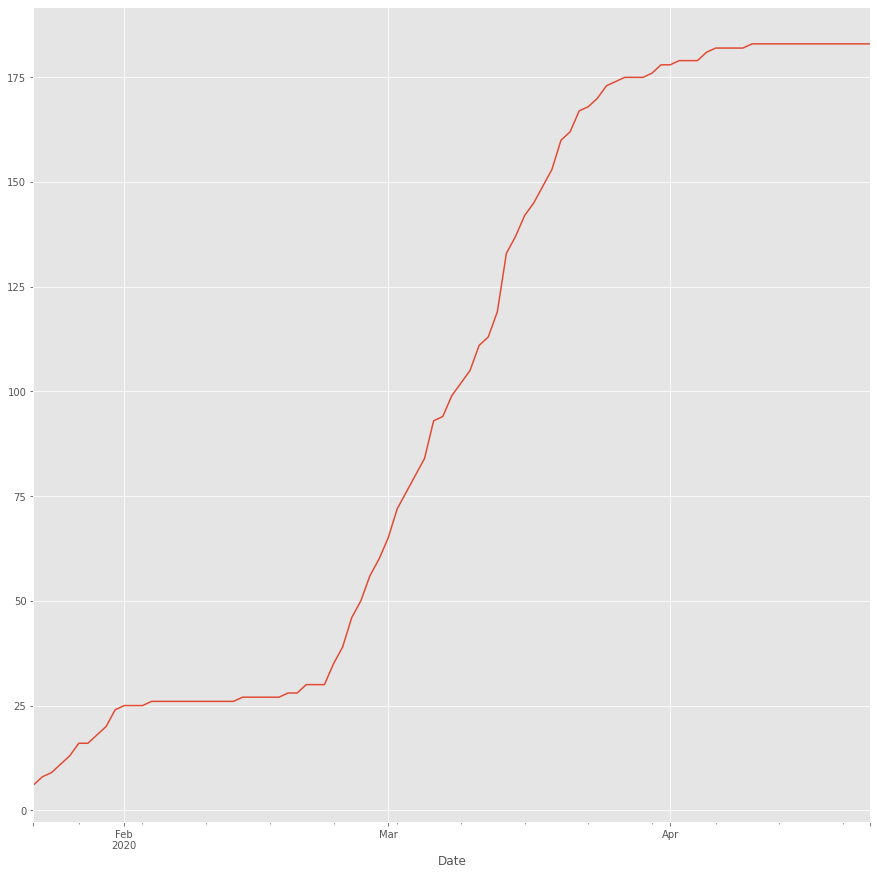

In [ ]:
#для начала определим количество стран, которые подтвердили случаи заражения, при этом не стоит забывать, что были обнаружены случаи не лайнерах, которые возможно тоже включены в выборку


#Проверим данные на дубликаты. Метод duplicated() возвращает серию логических значений (равны True, если аналогичная строка уже имеется в наборе данных). 
#Проверим, что никакие две записи не имеют одинаковые страну, область и дату.

print(sum(df.duplicated(['Country/Region', 'Province/State', 'Date'])))

#Cумма булевых значений может быть равна нулю только если все пункты равны False. Получается, что все строки набора данных уникальны и можно искать количество стран по .unique()

#создадим список с уникальными названиями в столбике "Country/Region"
country_list = df['Country/Region'].unique()

#теперь посмотрим, все ли строчки в данных - это страны, потому что возможно, как уже говорилось, в датасете есть лайнеры
#для этого воспользуемся импортированным датасетом со странами
all_countries = pd.read_csv('/content/country-and-continent-codes-list-csv_csv.csv')
all_countries.head()

#теперь создадим список с уникальными названиями стран из импортированного датасета
countries = []
for ind, row in all_countries.iterrows():
  country = all_countries.Country_Name[ind][: all_countries.Country_Name[ind].find(",")]
  countries.append(country)

#теперь пересечём множества, полученные из двух списков
c = list(set(country_list) - set(countries))
#и посмотрим на те страны, которые попали в пересечение
print(c)
#видим, что есть 2 круизных лайнера (Diamond Princess, MS Zaandam'), удалим их из датасета
df = df.loc[~df['Country/Region'].isin(['Diamond Princess', 'MS Zaandam'])]

country_list = df['Country/Region'].unique()

print('Коронавирус COVID19 обнаружен в {} странах:'.format(country_list.size))

for country in sorted(country_list):
    print('- {}'.format(country))


# теперь визуализируем количество стран, подтвердивших случаи заражения по дням

#шаг 1: оставим только дни у стран, когда подтвердили случаи заражения
df1 = df[df['Confirmed'] > 0]
#шаг 2: теперь сгруппируем по дате и возьмём уникальные страны
df2 = df1.groupby(by='Date')['Country/Region'].unique()

#теперь будем смотреть на изменение количество стран со случаями в течение всего времени по дням
l = []
for i in df2:
  s = len(i)
  l.append(s)

d = pd.DataFrame({'Countries': df2, 'nums':l})
d.nums.plot()

#по полученному графику можно сделать вывод, что примерно до середины февраля общее количество стран со случаями коронавируса оставалось на уровне около 25, но с середины февраля наблюдается резкий
#и большой скачок, такой, что уже через месяц колчичество стран превзошло отметку в 170.
#

#### 1.3 Теперь визуализируем мировые тренды по числу заболевших | погибших | выздоровивших и построим графики, которые отражают летальность от вируса в разных странах или на разных континентах. 

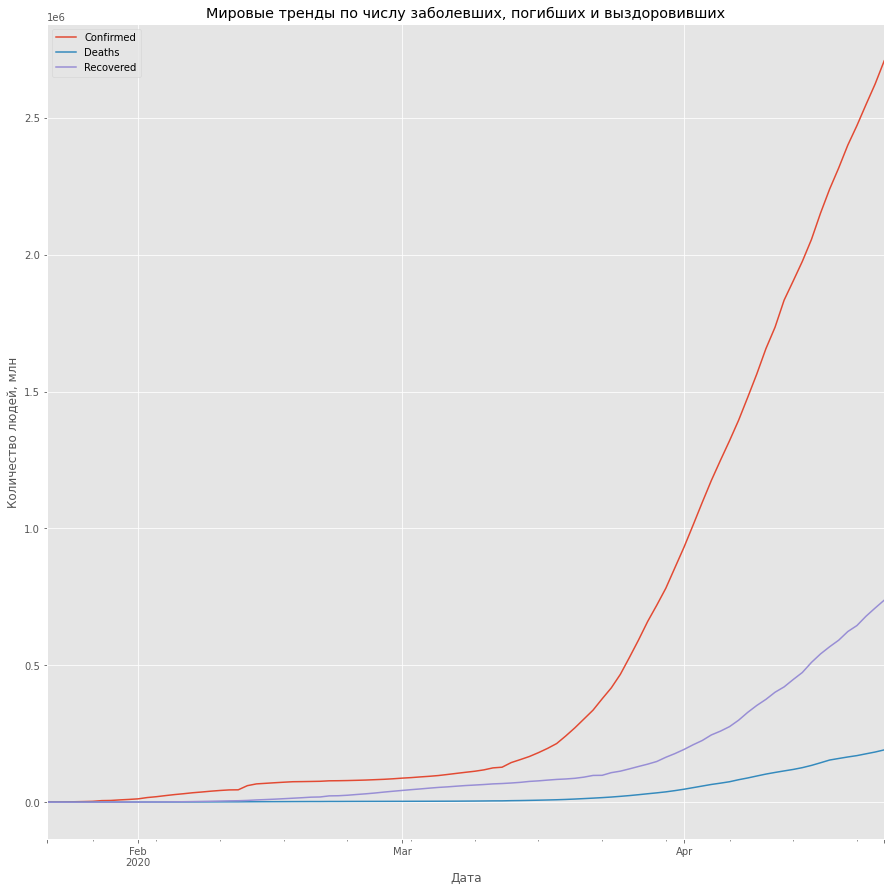

In [ ]:
#Визуализируем мировые тренды по числу заболевших | погибших | выздоровивших

#по количеству заболевших
df2 = df.groupby(by='Date')['Confirmed'].sum()
df2.plot(label = 'Confirmed')

#по количеству погибших
df2 = df.groupby(by='Date')['Deaths'].sum()
df2.plot(label = 'Deaths')

#по количеству выздоровивших
df2 = df.groupby(by='Date')['Recovered'].sum()
df2.plot(label = 'Recovered')

plt.ylabel('Количество людей, млн')
plt.xlabel('Дата')
plt.title('Мировые тренды по числу заболевших, погибших и выздоровивших')
plt.legend()

#Вывод: динамика мировых трендов похожа: до середины марта количество заболевеших, умерших и выздоровивших растёт умеренно медленно, а середины марта эти числа начинают расти очень быстро
#наиболее ярко этот тренд проявляется с количеством заболевших (за месяц число растёт в 5 раз от 0,5 млн до 2,5 млн)
#необходимо отметить, что эти тренды похожи на рост количества стран, показанный в прошлом задании, что логично: чем больше стран, тем больше заболевших, и, соответственно, умерших и выздоровивших
#положительный момент, представленный на графике - это то, что число выздоровивших людей превышает число умерших, что хоть немного успокаивает (из других источников была информация, что умирают больше дюди в возрасте и с другими доп. заболеваниями)


#теперь визуализируем летальность (во 2 части дз дана формула летальности для выполнения этого дз: #deaths/#confirmed - воспользуемся формулой)
mortality = df['Deaths']/df['Confirmed']
df['mortality'] = mortality
#построим график, отражающий летальность от вируса в разных странах по дням
#выбрано было по количеству стран, а не по континентам, потому что на самих континентах ситуация в разных странах развивалась достаточно по-разному (сведения из новостей)
#поэтому, на мой взгляд, лучше показать все страны на 1 графике, на который можно навестись и получить информацию о конкертно интересующей нас стране
mort = px.line(df, x='Date', y='mortality', color='Country/Region', title='Летальность от вируса в разных странах', hover_name='Country/Region')
mort.show()

#Вывод: из графика летальности можно сделать вывод, что смертность была высокой в Китае при появлении вируса, что естественно, потому что люди ещё не понимали, что это такое, насколько серьёзно и какие стоит принимать меры для приостановления распространения вируса
#Причём для Китая можно наблюдать несколько графиков, потому что в датасете есть отдельно провинции Китая (например, Хубей), и даже в них летальность в феврале была больше, чем в большинстве развитых стран сейчас
#при дальнейшем анализе летальности можно заключить, что летальность сильно выше в странах "третьего мира", чем в развитых, хотя эта закономерность типична не для всех развитых стран
#к примеру, в Великобритании тоже высокая смертность, что можно объяснить отказом страны от введения жёстких карантинных мер при возникновении опасноcти распространения вируса
#более того, можно заметить, что летальность выше в тех странах, где средний возраст выше, чем обычно (этим можно объяснить относительно высокую смертность в Италии, Испании)

#### 1.4 Визуализируем и сравним, как распространялась болезнь в разных странах или континентах по дням с первого зарегистрированного случая заболевания. Определим количество дней для каждой страны со дня первого зарегестрированного случая.

In [ ]:
#визуализируем и сравним, как распространялась болезнь в разных странах по дням с первого зарегистрированного случая заболевания

conf = px.line(df[df['Confirmed'] > 0], x='Date', y='Confirmed', color='Country/Region', title='Развитие болезни в разных странах по дням с первого зарегистрированного случая', hover_name='Country/Region')
conf.show()
#Вывод:до середины марта можно отметить, что выделяется на графике Китай, однако нельзя сказать, что количество заболевших сильно растёт с середины февраля, оно расёт умеренным линейным трендом
#однако с середины марта сильно выбивается США, они выделяются их всех стран своим стремительным ростом заболевших. Причиной этому может являться несвоевременная подготовка к пандемии и частная система здравоохранения, система страховок
#так же болезнь развивается быстро в Италии, Испании, возможно из-за непринятия карантинных мер вовремя
#быбстрее растёт количество заболевших в Великобритании

#теперь определим количество дней для каждой страны со дня первого зарегистрированного случая
df1 = df[df['Confirmed'] > 0]
df1.groupby(by='Country/Region').size()

Country/Region
Afghanistan           60
Albania               46
Algeria               59
Andorra               53
Angola                35
                      ..
West Bank and Gaza    50
Western Sahara        19
Yemen                 14
Zambia                37
Zimbabwe              35
Length: 183, dtype: int64

#### 1.5 Визуализируем и оценим, как развивалась ситуация в России по сравнению с остальными миром.

Populating the interactive namespace from numpy and matplotlib


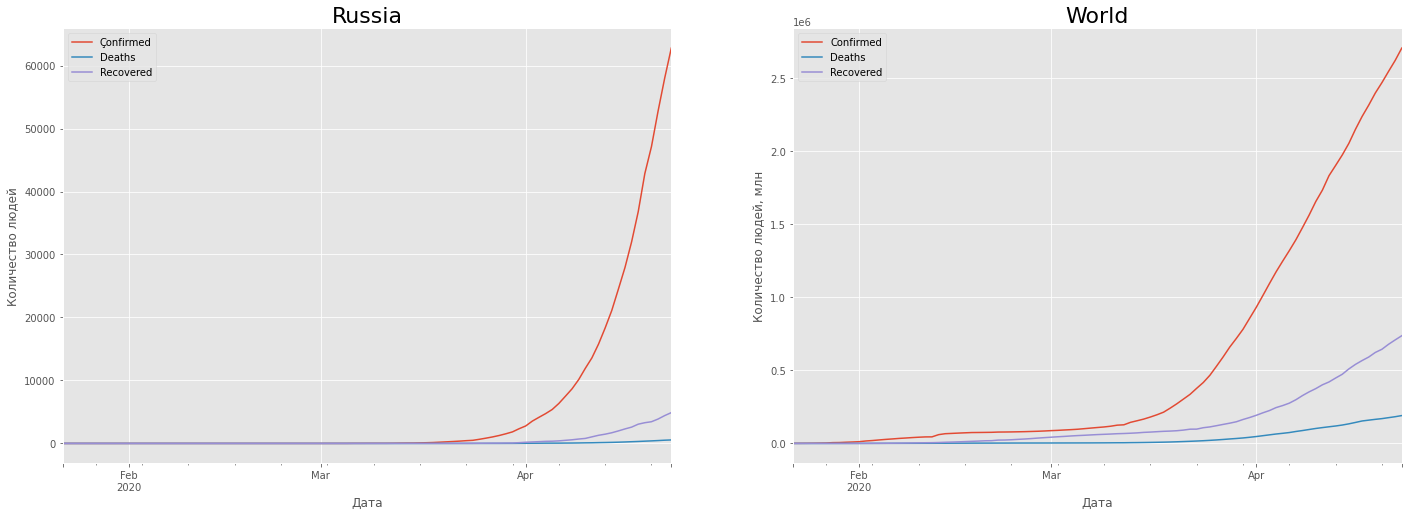

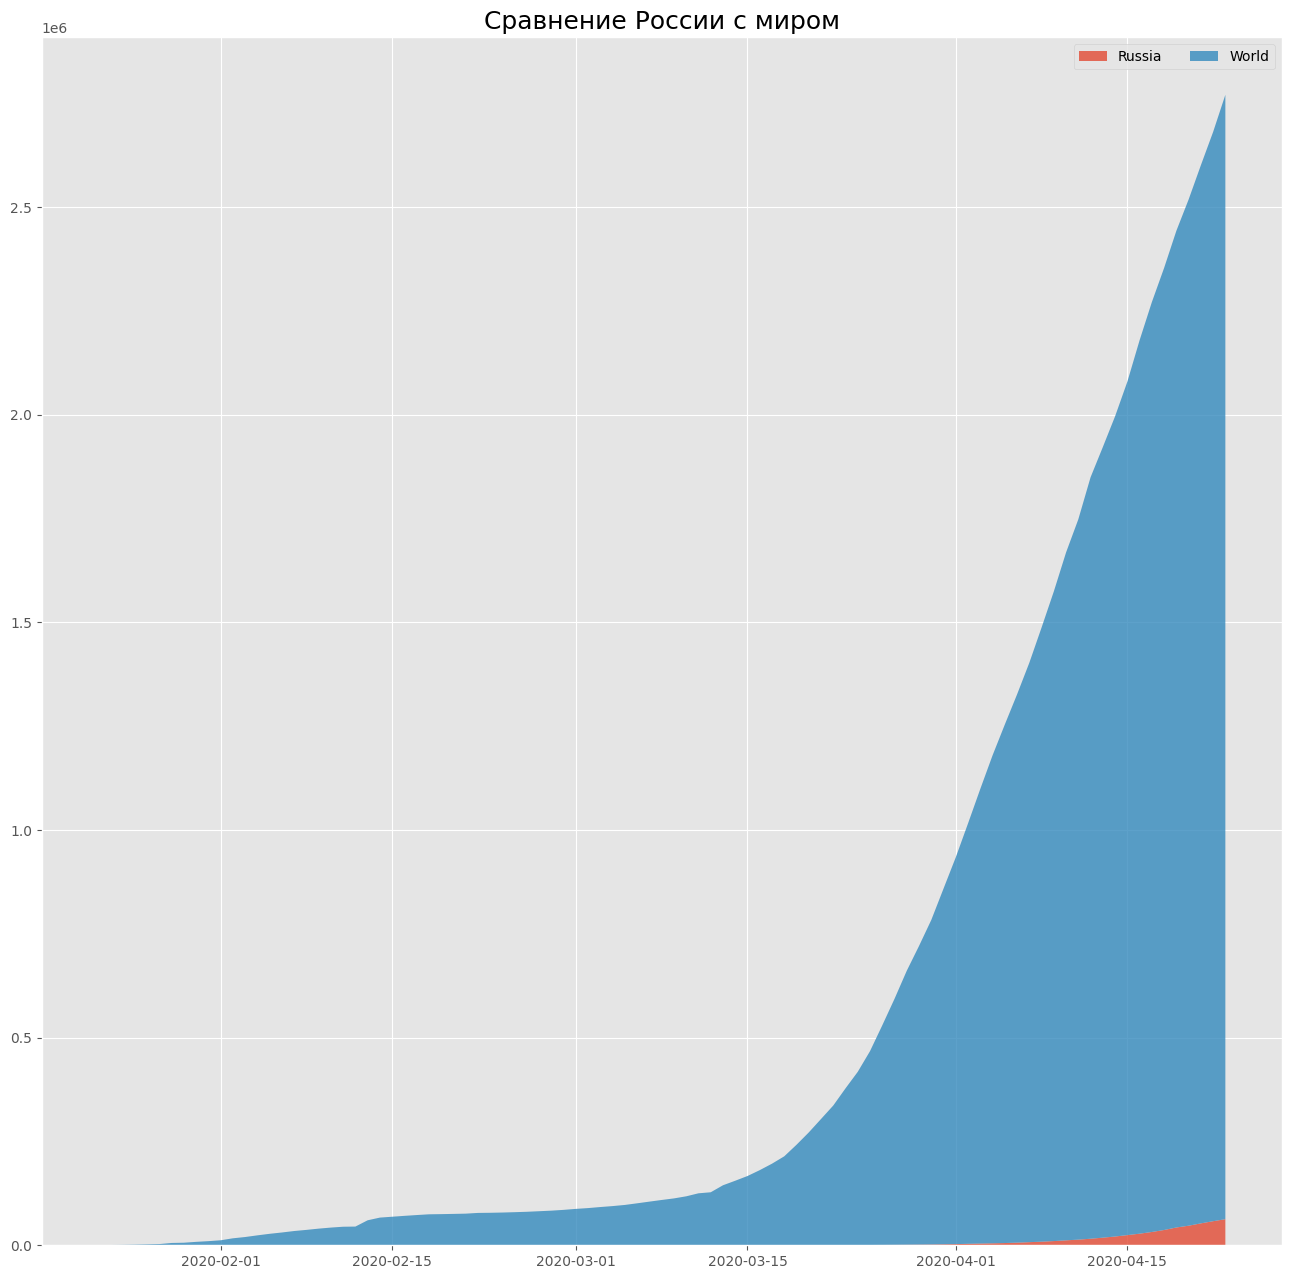

In [ ]:
#в задании подробно не сказано, как именно нужно визуализировать и оценить ситуацию с коронавирусом в России по сравнению с остальным миром, поэтому я решила показать 3 графика:
#в первых двух идёт сравнение количества заболевших, умерших и выздоровивших в России и в мире с помощью двух графиков, изображенных рядом, чтобы посмотреть, а похожи ли тренды
#3ий график - это диаграмма с областями с накоплением, она дает визуальное представление степени вклада от нескольких временных рядов.

%pylab inline
pylab.figure(figsize=(24,8))
# Ваш код здесь
df3 = df[df['Country/Region'] == 'Russia']
df3.index = pd.PeriodIndex(df3.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Russia', fontsize=22)
df3.Confirmed.plot(label = 'Çonfirmed')
df3.Deaths.plot(label = 'Deaths')
df3.Recovered.plot(label = 'Recovered')
plt.ylabel('Количество людей')
plt.xlabel('Дата')
plt.legend()

pylab.subplot(1,2,2)
plt.title('World', fontsize=22)
df1 = df[df['Confirmed'] > 0]
df1
df2 = df1.groupby(by='Date')['Confirmed'].sum()
df2.plot(label = 'Confirmed')
df1 = df[df['Deaths'] > 0]
df1
df2 = df1.groupby(by='Date')['Deaths'].sum()
df2.plot(label = 'Deaths')
df1 = df[df['Recovered'] > 0]
df1
df2 = df1.groupby(by='Date')['Recovered'].sum()
df2.plot(label = 'Recovered')

plt.ylabel('Количество людей, млн')
plt.xlabel('Дата')
plt.legend()

#Вывод: мы видим, что в целом тренды похожи, однако в России ситуация начинает значительно и резко ухудшаться в конце марта - начале апреля, а в мире - с середины марта и более плавно
#Более того, в России очень мало смертей по сравнению с мировой статистикой

#теперь посмотрим на диаграмму с накоплением, чтобы понять, какую примерно часть составляет Россия от общей статистики


# Draw Plot and Annotate
fig, ax = plt.subplots(1,1,figsize=(16, 16), dpi= 100)
columns = df.columns[1:]
labs = ['Russia', 'World']

# Prepare data
x  = df['Date'].unique()
y0 = df[df['Country/Region'] == 'Russia'].Confirmed.values.tolist()
y1 = df.groupby(by='Date')['Confirmed'].sum().tolist()
y = np.vstack([y0, y1])

# Plot for each column
ax = plt.gca()
ax.stackplot(x, y, labels=labs, alpha=0.8)

ax.set_title('Сравнение России с миром', fontsize=18)
ax.legend(fontsize=10, ncol=4)

plt.show()

#Вывод: число заболевших в России составляет только малую часть от общей мировой статистики

#### 1.6 Определим топ-10 стран, которые лидируют по имеющимся в датасете показателям. Сравним насколько быстро развивается ситуация в этих странах, определим корреляцию.

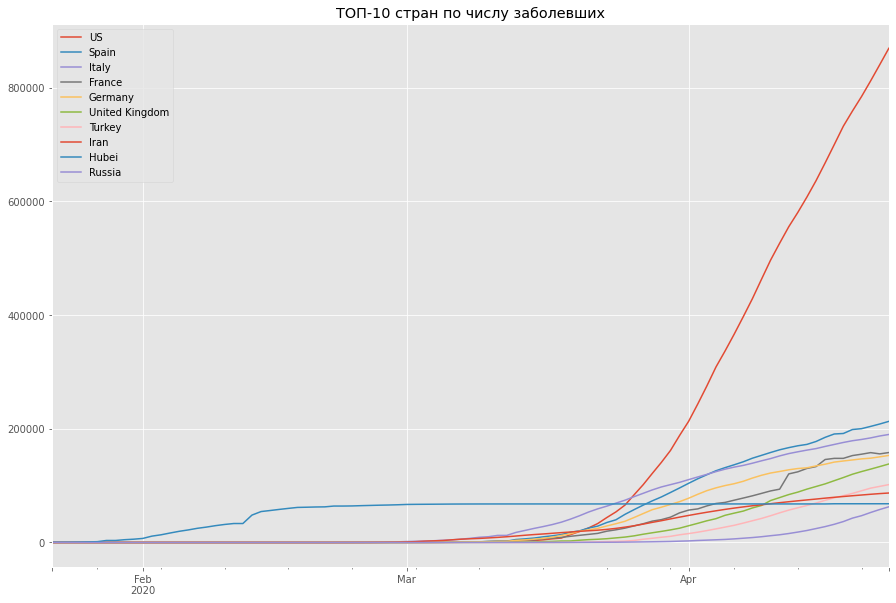

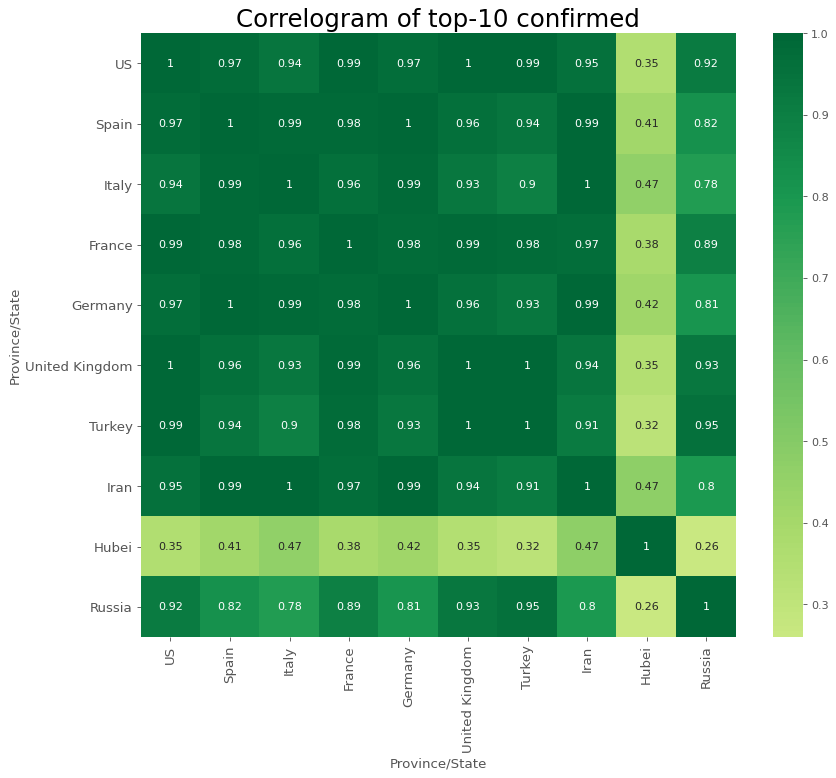

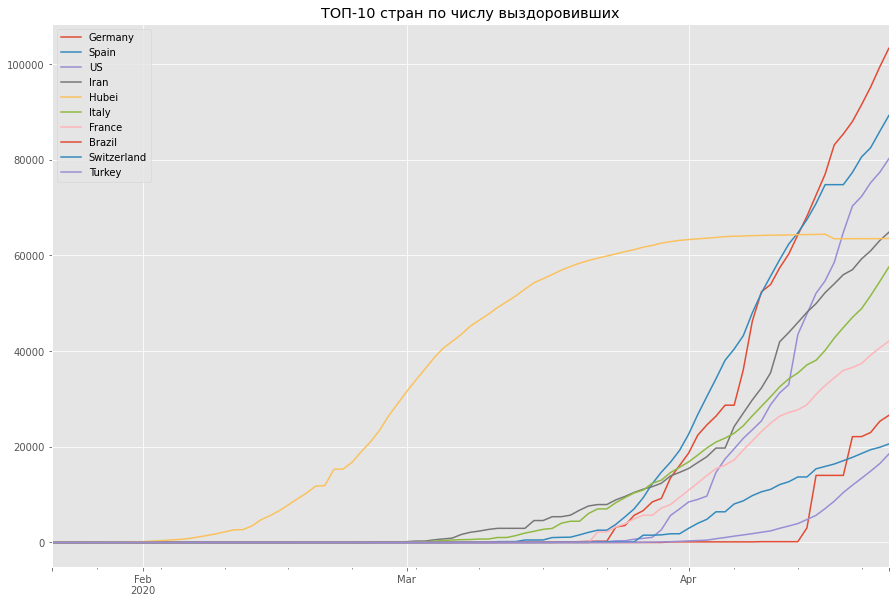

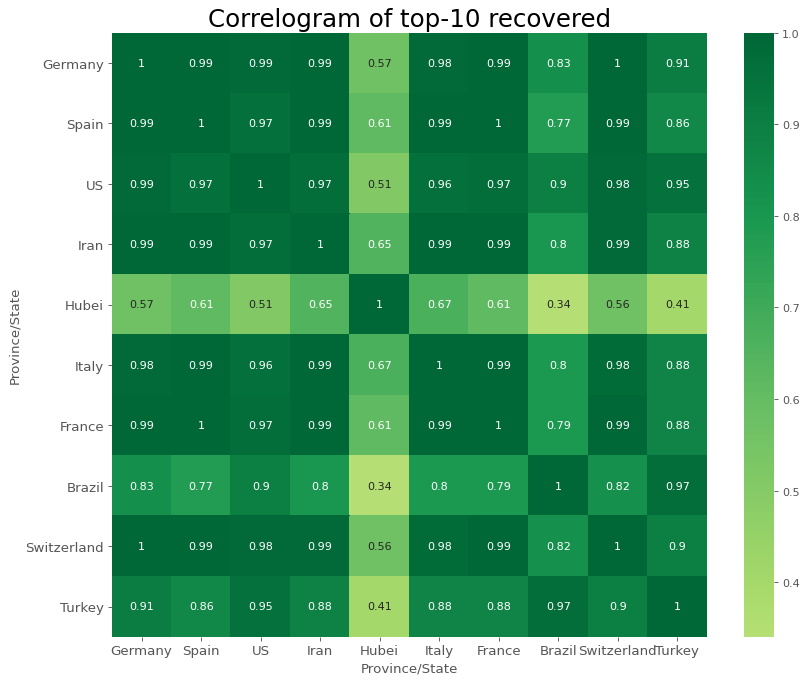

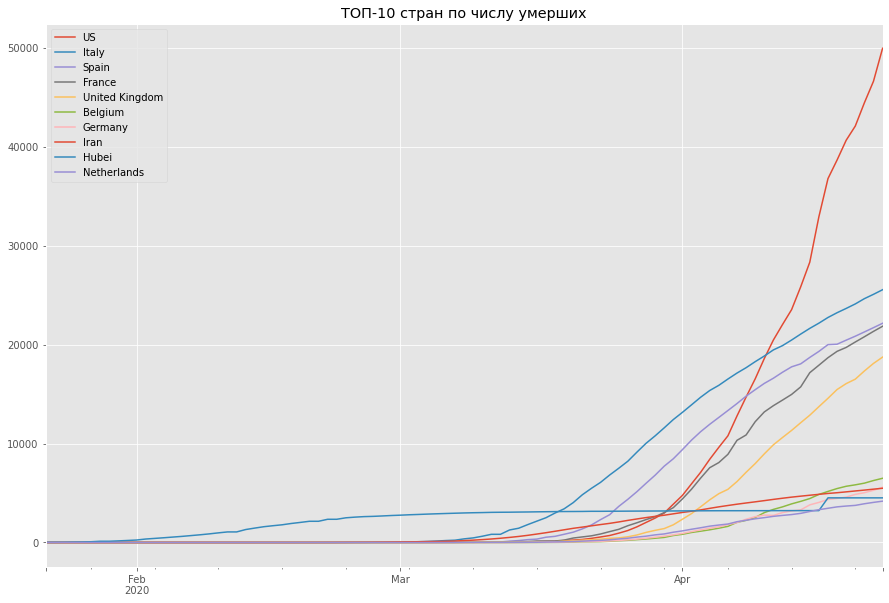

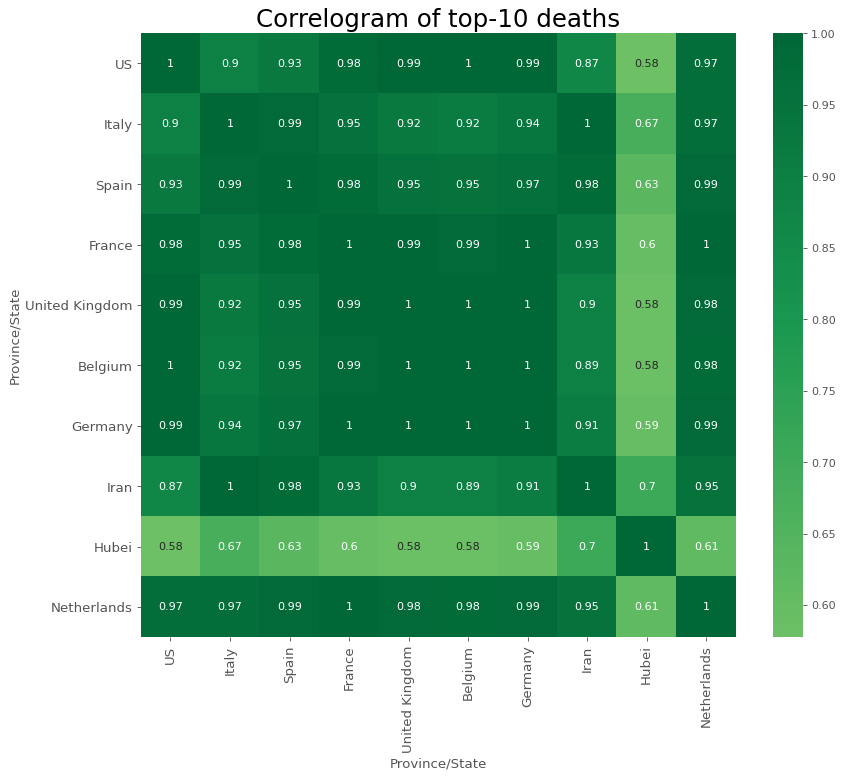

In [ ]:
#при подробном анализе данных было выявлено, что в некоторых странах провинция ведётся по провинциям/штатам, потому что ситуация в них отличается от общего положения страны ил просто статистика именно этой провинции интересней в отдельности
#проблема проявилась при выполнении этого задания, когда некоторые страны, от которых ожидалось появления в топе, не оказались в нём
#поэтому было принято решение заменить провинции на страны (если провинции != nan) - одно из потенциальных решений, предложенное составителем домашнего задания

#заменяем провиции и штаты на названия стран, чтобы не было типо 2 Китая и т д
state = df['Province/State'].fillna(df['Country/Region'])
df['Province/State'] = state
df.head()


import seaborn as sns


top_confirmed = df.loc[df['Date'] == list(df.Date)[-1]].sort_values(by = "Confirmed", ascending = False)[:10]
top_recovered = df.loc[df['Date'] == list(df.Date)[-1]].sort_values(by = "Recovered", ascending = False)[:10]
top_deaths = df.loc[df['Date'] == list(df.Date)[-1]].sort_values(by = "Deaths", ascending = False)[:10]

#топ-10 и корреляция для Confirmed

top = top_confirmed['Province/State']

#top_confirmed.index = pd.PeriodIndex(top_confirmed.Date.values,  freq='D')

#for i in top:
  #top_confirmed[top_confirmed['Country/Region'] == i].Confirmed.plot()

top
top_confirmed

data = pd.DataFrame(columns=top)

pylab.figure(figsize=(15,10))
for i in top:
  df_c = df.loc[(df['Province/State'] == i)]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
    #pylab.figure(figsize=(24,8))
  df_c.Confirmed.plot(label = i)
  data[i] = df_c.Confirmed

plt.title('ТОП-10 стран по числу заболевших')
plt.legend()

#Вывод: топ-10 стран по числу заболевших: США, Италия, Испания, Франция, Германия, Великобритания, Турция, Иран, Хубей (провинция в Китае), Россия
#США являются явным лидером в топе, догнать которго, скорее всего, никто не сможет. Этот результат согласуется с новостями о коронавирусе, что США больше всех страдают от пандемии
#в других странах темпы развития ситуации ускоряются значительно с середины марта
#предыдущее замечание не соответствует картине в Хубее, Китае, где число заражённых резко поднялось в середине февраля, но дальше не продолжило увеличиваться так сильно, как в других странах, попавших в топ
#следует заметить, что в России позже всех в топе начинает сильно увеличиваться число заражённых, при этом так быстро, что она уже в топе - это соотносится с прогнозами специалистов, которые ставят пик в России позднее


plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)

#если смотреть на корреляцию стран между собой по количеству заражённых, то сразу выбивается Хубей, Китай как регион, с которым мало коррелируют другие страны. Возможно, это связано с тем, что он был первопроходцем
#и вирус стал распространяться в других странах позже, когда уже в Хубее стабилизовалась ситуация (относительно других стран, конечно же). А может и потому, что рассматривается 1 провинция, а не вся страна
#что касается других стран, то корреляция очень высокая, что говорит о том, что вирус распространяется в топе стран примерно с одинаковыми темпами
#единственное, что ещё необходимо отметить, это корреляцию России с другими странами: она около 0.80, когда в других странах всё-таки больше 0.90.
#возможно, это так, потому что в Росси уверенный рост начался позже, как показано на графике выше

# Decorations
plt.title('Correlogram of top-10 confirmed', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#топ-10 и корреляция для Recovered

top = top_recovered['Province/State']


data = pd.DataFrame(columns=top)

pylab.figure(figsize=(15,10))
for i in top:
  df_c = df.loc[(df['Province/State'] == i)]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
    #pylab.figure(figsize=(24,8))
  df_c.Recovered.plot(label = i)
  data[i] = df_c.Recovered

plt.title('ТОП-10 стран по числу выздоровивших')
plt.legend()

#топ-10 стран по числу выздоровивших: Германия, Испания, США, Иран, Хубей, Италия, Франция, Бразилия, Швейцария, Турция
#страны пересекаются с топ-10 по подтверждённым случаям, что логично, однако есть и различия в топах: Бразилия, Россия, Швейцария
#возможно, что Россия не попала в топ-10 по выздоровишим, потому что в ней пик начался позже, чем в других странах в топе-10 по заражённым, и многие люди просто ещё не успели выздороветь к исследуемому периоду
#насчёт Швейцарии и Бразилии ничего не могу сказать
#отдельно по странам хотелось бы отметить, что лидирую по рассматриваемому показателю Германия и США, несмотря на факт, что в США намного больше заболевших
#также интересно отметить Хубей, в котором число выздоровиших достаточно большое для числа заболевших


plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of top-10 recovered', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#что касается корреляции для топ-10 по числу выздоровивших, то можно отметить, что ситуация с Хубеем такая же, как и в коррелограмме по числу заболевших
#очень высокая корреляция для стран ЕС, что неудивительно, потому что в этой зоне активная и легко доступная миграция (до карантина), поэтому люди из разных стран заражают друг друга
#однако опять же предыдущее утверждение больше объясняет прошлую коррелограмму, хотя Бразилии, к примеру, в ней не было и нельзя было примерно понять как соотносятся страны Европы и Латинской Америки
#возможно, что корреляция в европейских странах по числу выздоровивших очень высока, потому что условия жизни там похожи (здравоохранение, подготовленность к ЧС и т.д.)


#топ-10 и корреляция для умерших

top = top_deaths['Province/State']

data = pd.DataFrame(columns=top)

pylab.figure(figsize=(15,10))
for i in top:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c.Deaths.plot(label = i)
  data[i] = df_c.Deaths

plt.title('ТОП-10 стран по числу умерших')
plt.legend()


#В топ-10 для умерших входят США, Италия, Испания, Франция, Великобритания, Бельгия, Германия, Иран, Хубей, Нидерланды
#США, как и топе-10 по числу заражённых лидирует с серьёзным разрывом от других стран, возможно, потому что страна до последнего не была готова к пандемии и здравоохранение там частное и доступно не каждому
#в США даже коек не хватает, что уж говорить о количестве аппаратов ИВЛ, поэтому ситуация с числом умерших от вируса неудивительна
#далее идут страны Европы, наверное, потому что в них средний возраст человека выше, чем в других странах, а считается, что от вируса, в первую очередь, умирают пожилые, хотя сейчас уже стали умирать людт любого возраста
#в Хубее, Китае, число умерших выходит на "плато"

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(data.corr(), xticklabels=data.corr().columns, yticklabels=data.corr().columns, cmap='RdYlGn', center=0, annot=True)

# Decorations
plt.title('Correlogram of top-10 deaths', fontsize=22)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

#что касается коррелограммы, то в целом ситуация похожа на те, что были описаны выше: корреляция высокая, особенно у близких стран, с Хубеем корреляция низкая

1.7 Для первых 5 стран из топ-10 и России построим сравнительные графики. Изучим как изменялись значения отношений погибших/выздоровивших, погибших/заболевших, заболевших/общее число жителей...

        Date Country/Region Province/State   Lat  ...  World Share  d/r  d/c  c/p
0 2020-01-22    Afghanistan    Afghanistan 33.00  ...       0.50 %  nan  nan 0.00
1 2020-01-23    Afghanistan    Afghanistan 33.00  ...       0.50 %  nan  nan 0.00
2 2020-01-24    Afghanistan    Afghanistan 33.00  ...       0.50 %  nan  nan 0.00
3 2020-01-25    Afghanistan    Afghanistan 33.00  ...       0.50 %  nan  nan 0.00
4 2020-01-26    Afghanistan    Afghanistan 33.00  ...       0.50 %  nan  nan 0.00

[5 rows x 24 columns]


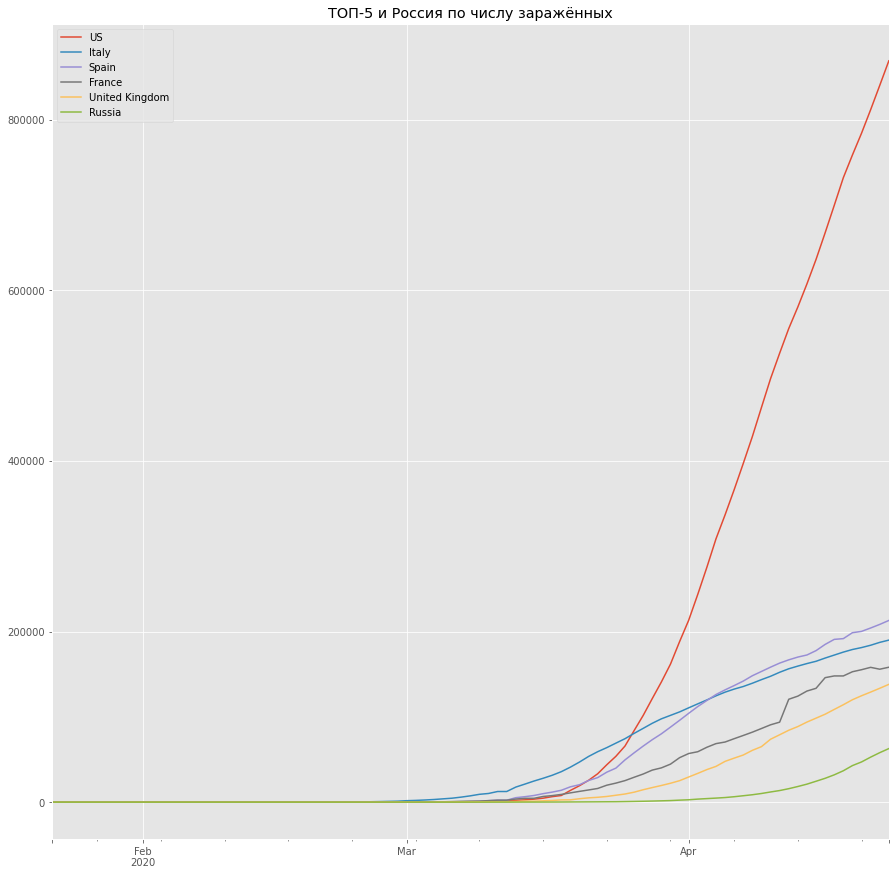

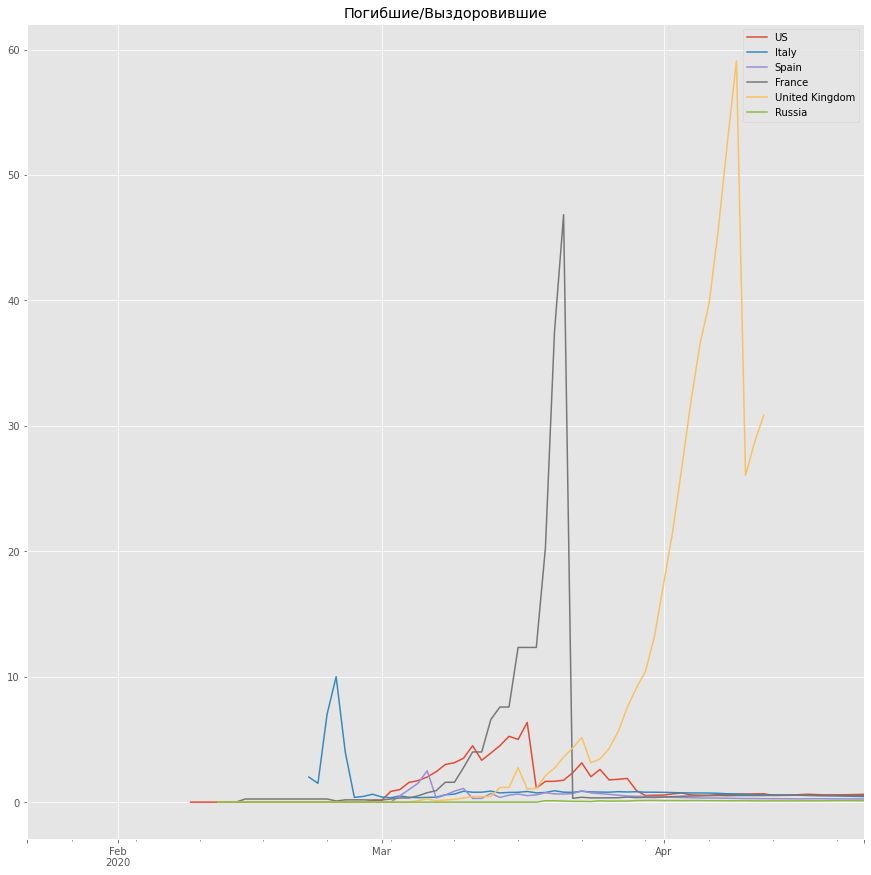

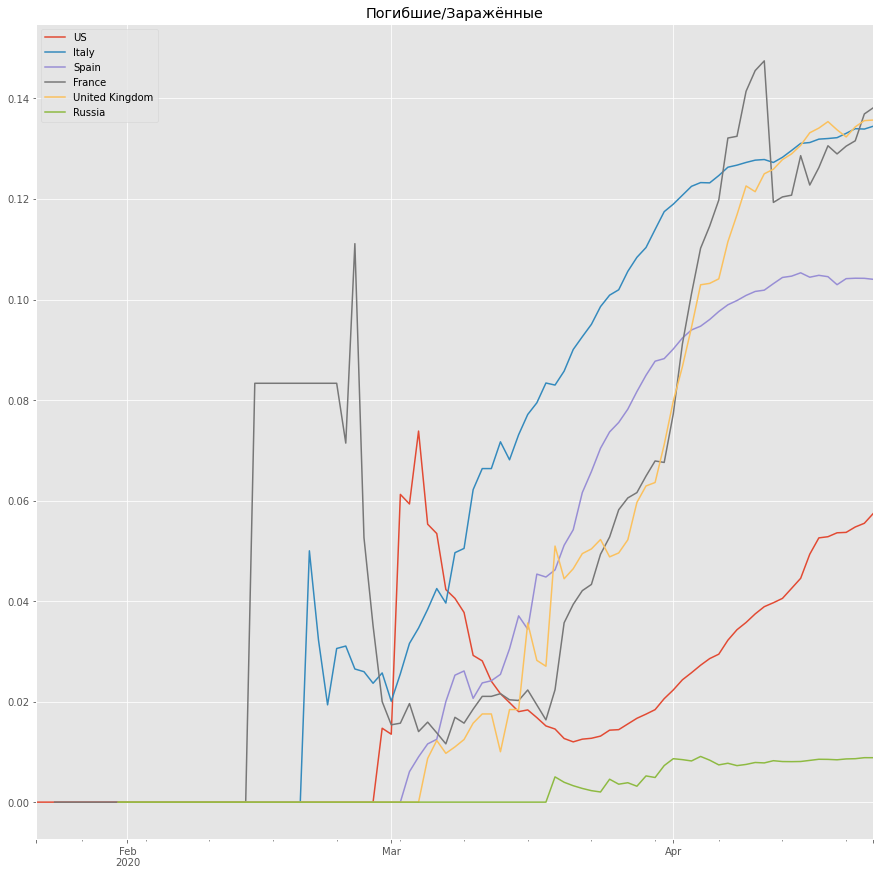

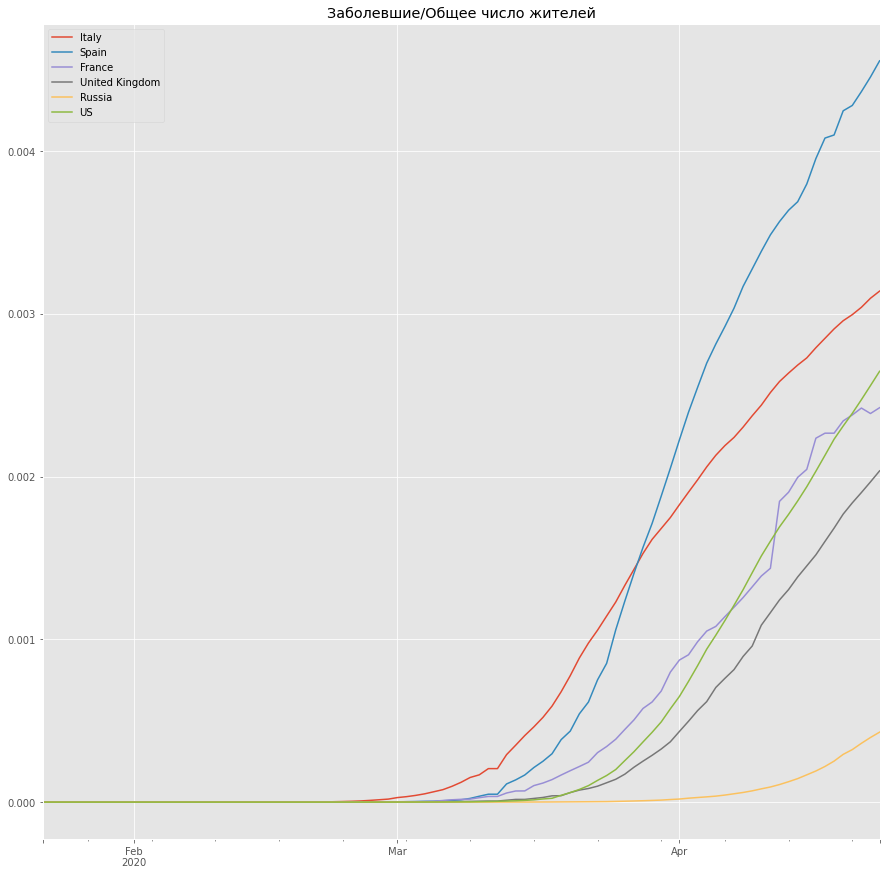

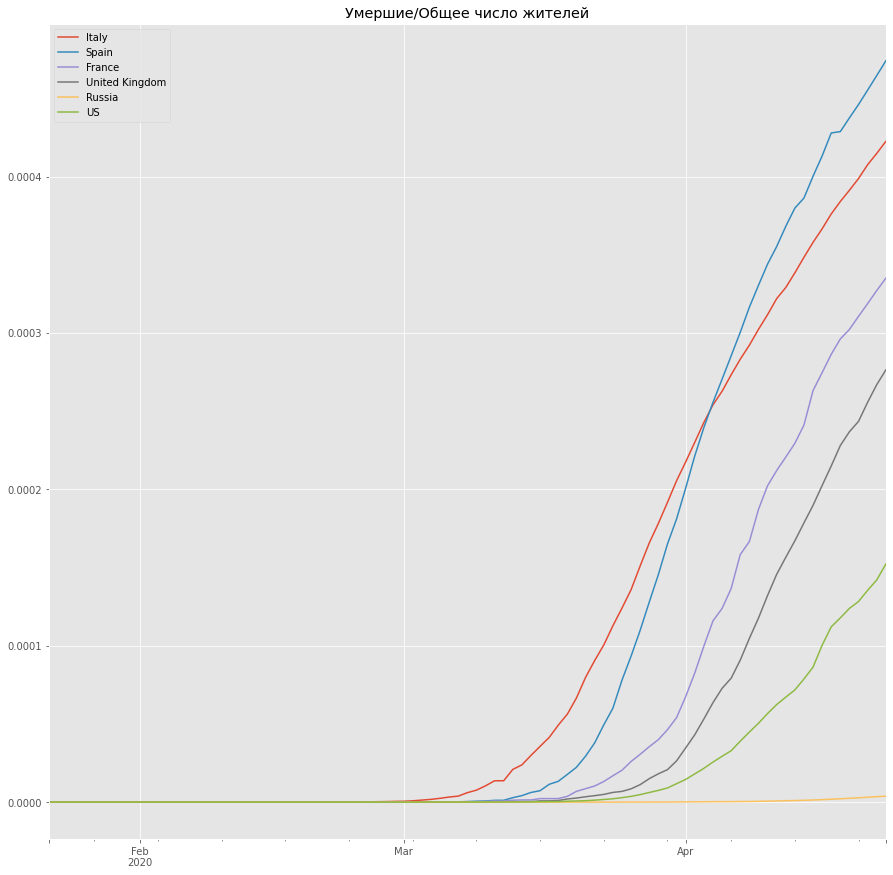

In [ ]:
#для начала импортируем датасет с численностью по странам на 2020 год для нахождения общего числа жителей в каждой выбранной стране

pop = pd.read_csv('/content/population_by_country_2020.csv')
pop['Country/Region'] = pop['Country (or dependency)']

#соединим этот датасет с датасетом по коронавирусу

df = df.merge(pop, on='Country/Region', how='left')

#выразим отношения погибших/выздоровиших, погибших/заболевших, заболевших/общее число жителей и добавим их как столбики в датасет

df['d/r'] = df['Deaths']/df['Recovered']
df['d/c'] = df['Deaths']/df['Confirmed']
df['c/p'] = df['Confirmed']/df['Population (2020)']
print(df.head())

#сравнительный график топ-5 стран и России

pylab.figure(figsize=(15,15))
for i in top[:5]:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c['Confirmed'].plot(label = i)
df_rus = df[df['Province/State'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')
df_rus['Confirmed'].plot(label = 'Russia')

plt.title('ТОП-5 и Россия по числу заражённых')
plt.legend()

#изменение значений отношения погибших к выздоровившим

pylab.figure(figsize=(15,15))
for i in top[:5]:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c['d/r'].plot(label = i)
df_rus = df[df['Province/State'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')
df_rus['d/r'].plot(label = 'Russia')

plt.title('Погибшие/Выздоровившие')
plt.legend()

#из графиков следует отметить два пика во Франции и в Великобритании, однако если во Франции этот коэффициент падает после пика, то в Великобритании он падает, но при этом остается высоким в сравнении с другими странами
#в других странах данное соотношение не поднималось выше 10, в России оно вообще очень маленькое

#изменение значений отношения погибших к заражённым

pylab.figure(figsize=(15,15))
for i in top[:5]:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c['d/c'].plot(label = i)
df_rus = df[df['Province/State'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')
df_rus['d/c'].plot(label = 'Russia')

plt.title('Погибшие/Заражённые')
plt.legend()

#на мой взгляд, по отношению погибших к заболевшим можно разделить страны на 3 группы: Россия, где оно относительно других стран небольшое относительно других стран, 
#США и Франция, где коэффициент сначала резко растёт, потом падает и потом снова стремительными темпами растёт
#и другие страны, где коэффциент растёт всегда

#изменение значений отношения заболевших к общему числу жителей

pylab.figure(figsize=(15,15))
for i in top[1:5]:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c['c/p'].plot(label = i)
df_rus = df[df['Province/State'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')
df_rus['c/p'].plot(label = 'Russia')
df_us = df[df['Province/State'] == 'US']
df_us['c/p'] = df[df['Province/State'] == 'US'].Confirmed/328200000
df_us.index = pd.PeriodIndex(df_us.Date.values,  freq='D')
df_us['c/p'].plot(label = 'US')

plt.title('Заболевшие/Общее число жителей')
plt.legend()

#по рассматриваемому коэффициенту лидируют Италия и Испания, неудивительно, потому что эти страны поздно ввели карантин и возможно, потому что в их менталитете приняты контакты с людьми на очень близком расстоянии
#Россия, как и в случаях выше, выделяется своим невысоким коэффициентом

#изменение значений отношения умерших к общему числу жителей

df['d/p'] = df['Deaths']/df['Population (2020)']

pylab.figure(figsize=(15,15))
for i in top[1:5]:
  df_c = df[df['Province/State'] == i]
  df_c.index = pd.PeriodIndex(df_c.Date.values,  freq='D')
  #pylab.figure(figsize=(24,8))
  df_c['d/p'].plot(label = i)
df_rus = df[df['Province/State'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')
df_rus['d/p'].plot(label = 'Russia')
df_us = df[df['Province/State'] == 'US']
df_us['d/p'] = df[df['Province/State'] == 'US'].Deaths/328200000
df_us.index = pd.PeriodIndex(df_us.Date.values,  freq='D')
df_us['d/p'].plot(label = 'US')

plt.title('Умершие/Общее число жителей')
plt.legend()

#данный коэффициент похож на предыдущий, но США здесь на 2 месте снизу после России, значит, есть хоть какие-то положительные заключения для США

1.8 Выделим временной ряд по одному из целевых признаков. Для выделенного временного ряда:
  - Представим временной ряд в виде последовательности разницы между значениями. Рассчитайтаем лаги, выведим их на графике.
  - Попробуем декомпозировать временной ряд. Построим график тренда.
  - Что можно сказать о стационарности временного ряда? 

                 Date Country/Region  ... ConfirmedDiff  ConfirmedDiffShift1
2020-01-22 2020-01-22         Russia  ...           nan                  nan
2020-01-23 2020-01-23         Russia  ...          0.00                  nan
2020-01-24 2020-01-24         Russia  ...          0.00                 0.00
2020-01-25 2020-01-25         Russia  ...          0.00                 0.00
2020-01-26 2020-01-26         Russia  ...          0.00                 0.00

[5 rows x 28 columns]


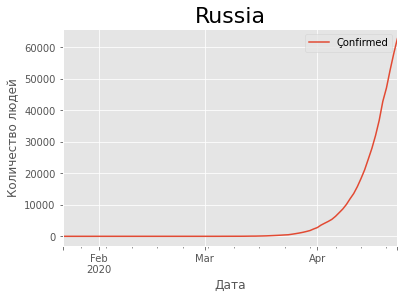

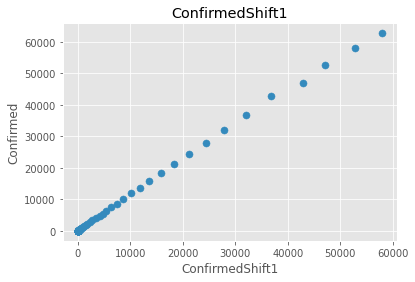

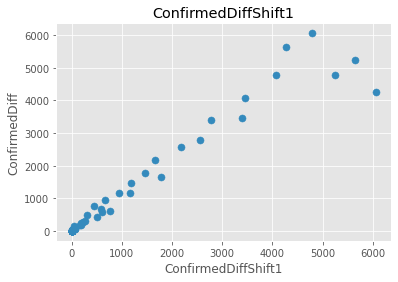

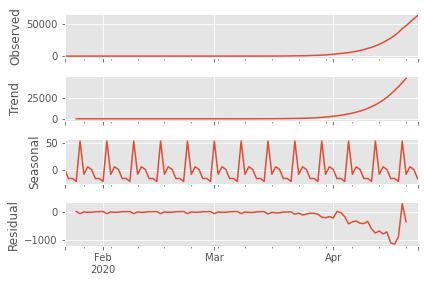

In [ ]:
#импортируем seasonal_decompose для декомпозиции временного ряда
from statsmodels.tsa.seasonal import seasonal_decompose

#выделим временной ряд по признаку "Confirmed" и покажем его на графике
df_rus = df[df['Country/Region'] == 'Russia']
df_rus.index = pd.PeriodIndex(df_rus.Date.values,  freq='D')

plt.title('Russia', fontsize=22)
df_rus.Confirmed.plot(label = 'Çonfirmed')
plt.ylabel('Количество людей')
plt.xlabel('Дата')
plt.legend()

# Рассчитаем лаги
# Выведем на графике полученные лаги ConfirmedShift1 и исходные данные Confirmed
df_rus["ConfirmedShift1"] = df_rus.Confirmed.shift()
df_rus.plot(kind= "scatter", y = "Confirmed", x = "ConfirmedShift1", s = 50, title='ConfirmedShift1')

#Теперь представим временной ряд в виде последовательности разницы между значениями 
df_rus["ConfirmedDiff"] = df_rus.Confirmed - df_rus.ConfirmedShift1
#df_rus.ConfirmedDiff.plot()

#в задании не очень понятно, имелись ли в виду лаги для исходного ряда или для ряда в виде последовательности разницы между значениями, поэтому вывыдем и лаги для ряда дельт
df_rus["ConfirmedDiffShift1"] = df_rus.ConfirmedDiff.shift()
df_rus.plot(kind= "scatter", y = "ConfirmedDiff", x = "ConfirmedDiffShift1", s = 50, title='ConfirmedDiffShift1')
print(df_rus.head())

#декомпозируем временной ряд и построим график тренда
df_rus.index = df_rus.index.to_timestamp()

decomposition = seasonal_decompose(df_rus.Confirmed, model = "additive")
decomposition.plot()
trend = decomposition.trend
#trend.plot()

#Вывод: в выбранных для анализа данных наблюдается явный тренд, который во многом объясняет динамику изменния данных во времени
#наличие тренда автоматически говорит о стационарности ряда, с которой необходимо бороться, иначе можно получить неверные предсказания (во 2 части домашнего задания ряды дифференцируются)

1.9 Построим графики ACF и PACF для временного ряда разностей по числу подтвержденных случаев в России.

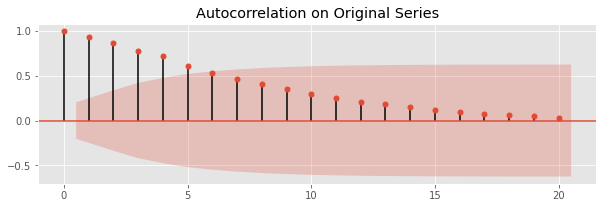

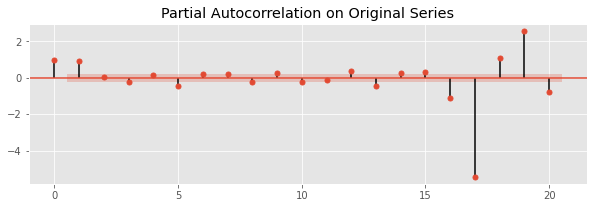

In [ ]:
#импортируем ACF и PACF 
from statsmodels.tsa.stattools import acf, pacf

#интересующий ряд - временной ряд разностей по числу подтверждённых случаев в России

#построим график ACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_acf = plt.figure(figsize=(10, 10))
ax1 = fig_acf.add_subplot(311)
fig_acf = plot_acf(df_rus['ConfirmedDiff'].dropna(), ax=ax1,
               title="Autocorrelation on Original Series") 

#Вывод: по графику видно, что 5 лагов автокорреляционной функции значимы, поэтому можно взять за начальное приближение при поиске модели АРМЫ для данного ряда q = 5

#построим график PACF
fig_pacf = plt.figure(figsize=(10, 10))
ax1 = fig_pacf.add_subplot(311)
fig_pacf = plot_pacf(df_rus['ConfirmedDiff'].dropna(), ax=ax1,
               title="Partial Autocorrelation on Original Series")

#Вывод: по графику частичной автокорреляционной функции можно сделать вывод, что p = 1 при подборе модели АРМА, потому что значим только один несезонный лаг

#### 1.10. Изучаемый датасет отражает текущую мировую статистику распространения болезни. Однако эти данные не дают нам возможноси предположить о возможных факторах, которые влюяют на скорость распространения, летальности, заразность и тд. Поэтому в наш датасет можно добавить новые признаки из других наборов данных, которые могут не только помочь при прогнозировании временного ряда, но и определить наиболее значимые факторы.

- Добавим новый признак "количество дней со дня первого случая заражения". Добавьте еще не менее 5 новых признаков в датасет, которые могут быть значимым фактором распространения вируса. 
- Исследуем, как добавленные признаки соотносятся с трендами распространения короновируса в некоторых странах. 

*Примеры признаков - количество дней со начала карантина, конинент, плотность населения, количество употребляемого алкоголя, летучих мышей, алкоголя, крокодилов на душу населения, количество туристов в год, уровень безработицы, температура, количество игроков в Plague Inc., средний возраст или продолжительность жизни и так далее. 

  Примеры датасеты:
  1. [500 Cities: Local Data for Better Health (2019)](https://www.kaggle.com/jaimeblasco/500-cities-local-data-for-better-health-2019)
  2. [Daily global surface summary from over 9000 weather stations from 1929 to now](https://www.kaggle.com/noaa/gsod)
  3. [Population by Country - 2020](https://www.kaggle.com/tanuprabhu/population-by-country-2020)



In [ ]:
#определите кол-во дней для каждой страны со дня первого зарегистрированного случая и создадим признак nums = "количество дней со дня первого случая заражения"

province_list = df['Province/State'].unique()
nums = []
for i in province_list:
  df_i = df[df['Province/State']==i]
  nums_i = []
  for ind in range(len(df_i)):
    if df_i.iloc[ind]['Confirmed'] == 0:
      nums_i.append(-1)
    else:
      nums_i.append(len(df_i.iloc[:ind]) - nums_i.count(-1))
  nums.append(nums_i)
numbers = [] 
for i in nums:
  for j in i:
    numbers.append(j)
numbers
df['nums'] = numbers
df.head()

#Теперь добавим ещё не менее 5 новых признаков а датасет, которые могут быть значимы
#Из признаков возьмём ещё возраст, плотность, населенность, мигранты, городское население и посмотрим, как они соотносятся с трендами распространения коронавируса в некоторых странах

Date Country/Region Province/State   Lat  ...  d/c  c/p  d/p  nums
0 2020-01-22    Afghanistan    Afghanistan 33.00  ...  nan 0.00 0.00    -1
1 2020-01-23    Afghanistan    Afghanistan 33.00  ...  nan 0.00 0.00    -1
2 2020-01-24    Afghanistan    Afghanistan 33.00  ...  nan 0.00 0.00    -1
3 2020-01-25    Afghanistan    Afghanistan 33.00  ...  nan 0.00 0.00    -1
4 2020-01-26    Afghanistan    Afghanistan 33.00  ...  nan 0.00 0.00    -1

[5 rows x 26 columns]

['Monaco']
['Mongolia' 'Western Sahara']


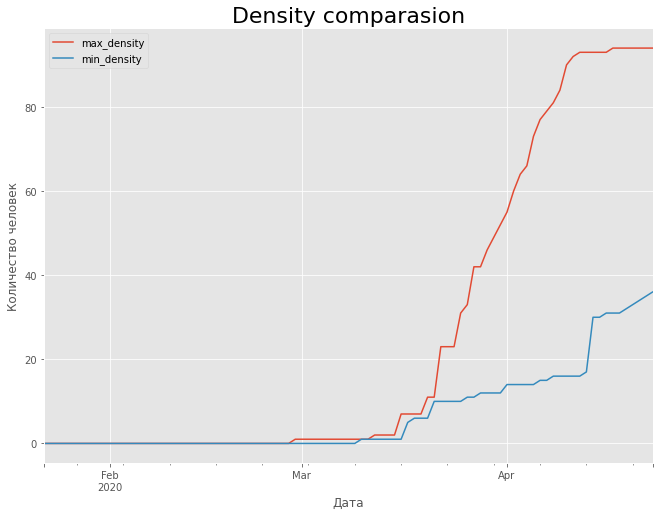

In [ ]:
#для начала определим страны с максимальной/минимальной плотностью населения, чтобы сравнить ситуацию распространения вируса в зависимости от плотности страны
max = df['Density (P/Km²)'].max()
c_max = df[df['Density (P/Km²)'] == max]['Province/State'].unique()
min = df['Density (P/Km²)'].min()
c_min = df[df['Density (P/Km²)'] == min]['Province/State'].unique()
print(c_max)
print(c_min)

#возьмём Монако как страну с максимальной плотностью населения и Монголию как страну с минимальной плотностью и сравним
pylab.figure(figsize=(24,8))
# Ваш код здесь
df_max = df[df['Country/Region'] == 'Monaco']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Country/Region'] == 'Mongolia']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Density comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_density')
df_min.Confirmed.plot(label = 'min_density')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#Видим, что в стране с минимальной плотностью - Монголией - вирус распространяется медленней, чем в стране с максимальной плотностью, что вполне оправдано. Данный признак хорошо подойдет к анализу

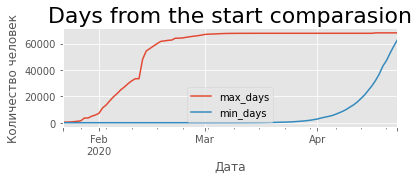

In [ ]:
#теперь посмотрим на страны с макимальным количеством дней распространения вируса и на те, где вирус было обнаружен сравнительно недавно

#Хубей - первопроходец, а в России значительно позже обнаружили вирус, посмотрим, как этот факт отражается на статистике
df_max = df[df['Province/State'] == 'Hubei']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Province/State'] == 'Russia']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(2,1,2)
plt.title('Days from the start comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_days')
df_min.Confirmed.plot(label = 'min_days')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#мы видим, что несмотря на то, что в России вирус был обнаружен значительно позже, чем в очаге заражения, за месяц число заражённых успело сравняться с числом заражённых в Хубее

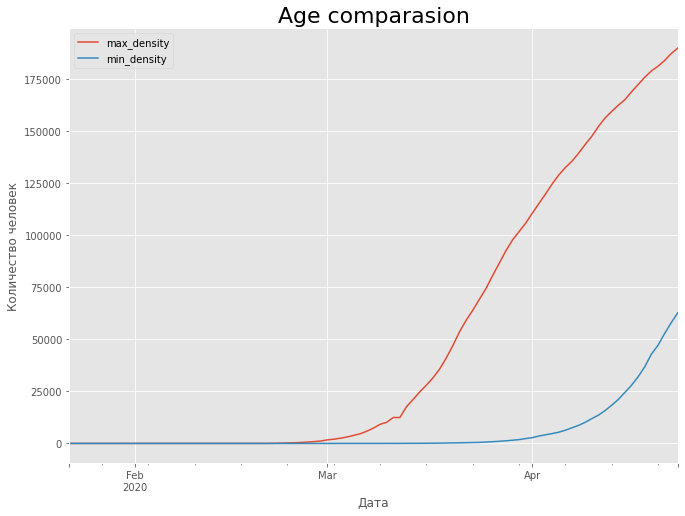

In [ ]:
#теперь сравним тренды в странах с высоким средним возрастом и не очень, чтобы сравнить ситуацию распространения вируса в зависимости от среднего возраста гражданина страны

#возьмём Италию как страну с максимальным средним возрастом населения и Россиию как страну с минимальным средним возрастом и сравним
pylab.figure(figsize=(24,8))
# Ваш код здесь
df_max = df[df['Country/Region'] == 'Italy']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Country/Region'] == 'Russia']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Age comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_density')
df_min.Confirmed.plot(label = 'min_density')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#как и следовало ожидать: в стране с более высоким возрастом коронавирус распространяется быстрее (и, кстати говоря, больнее)

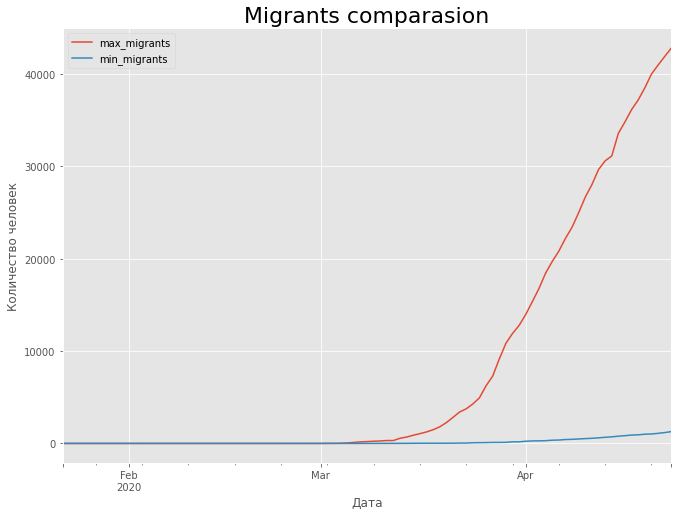

In [ ]:
#теперь возьмём две страны, где поток мигрантов большой и маленький: Бельгия и Афганистан соответственно

pylab.figure(figsize=(24,8))
# Ваш код здесь
df_max = df[df['Country/Region'] == 'Belgium']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Country/Region'] == 'Afghanistan']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Migrants comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_migrants')
df_min.Confirmed.plot(label = 'min_migrants')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#в стране со значительным положительным притоком мигрантов, ситуация с коронавирусом намного хуже, чем там, где поток мигрантов минимальный (и даже отрицательный)
#это логично, потому что мигранты могут привезти вирус из других стран

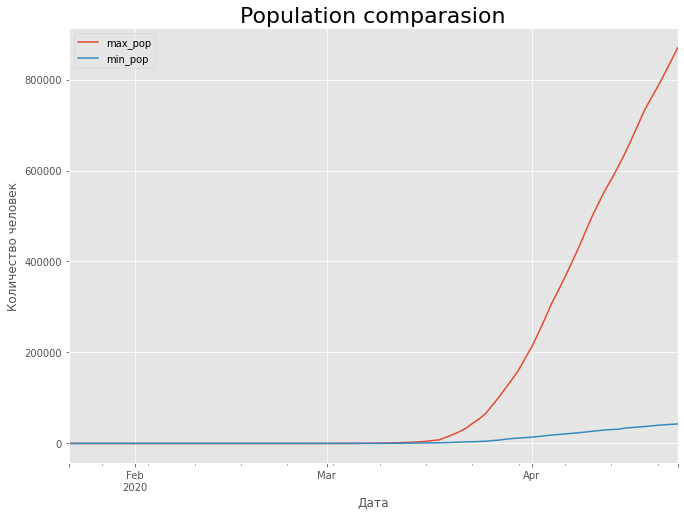

In [ ]:

#возьмём США как страну с большой численностью населения и Бельгию с меньшей численностью  и сравним
pylab.figure(figsize=(24,8))
# Ваш код здесь
df_max = df[df['Country/Region'] == 'US']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Country/Region'] == 'Belgium']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Population comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_pop')
df_min.Confirmed.plot(label = 'min_pop')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#Мы видим, что ситуация коронавируса хуже там, где численность населения больше

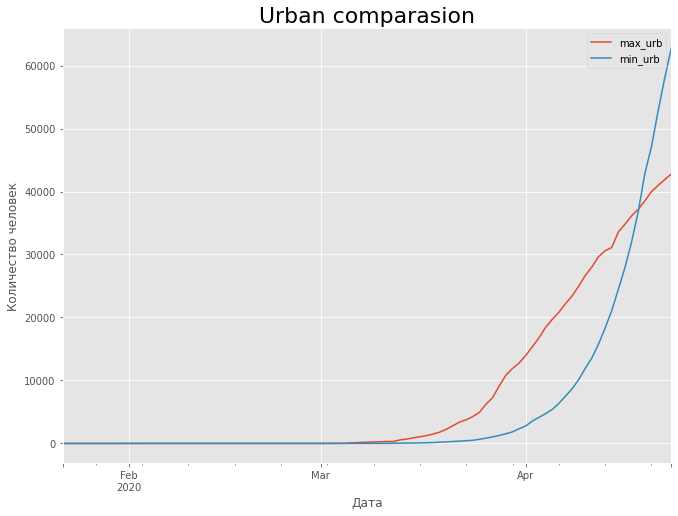

In [ ]:
#возьмём Бельгию как страну с большой долей городского населения и Россию как страну с меньшей долей городского населения и сравним
pylab.figure(figsize=(24,8))
# Ваш код здесь
df_max = df[df['Country/Region'] == 'Belgium']
df_max.index = pd.PeriodIndex(df_max.Date.values,  freq='D')
df_min = df[df['Country/Region'] == 'Russia']
df_min.index = pd.PeriodIndex(df_min.Date.values,  freq='D')

pylab.subplot(1,2,1)
plt.title('Urban comparasion', fontsize=22)
df_max.Confirmed.plot(label = 'max_urb')
df_min.Confirmed.plot(label = 'min_urb')
plt.ylabel('Количество человек')
plt.xlabel('Дата')
plt.legend()

#нельзя сделать точного вывода, зависит ли число заболевших от доли городского населения, но попробуем ввести эту переменную для дальнейшего анализа, в худшем случае она будет просто незначима

In [ ]:
#Тепепрь выберем только те данные, которые нам понадобятся ниже во 2 части
dataset = df[['Date', 'Country/Region', 'Province/State', 'mortality', 'month', 'Population (2020)', 'Density (P/Km²)', 'Migrants (net)', 'Med. Age', 'Urban Pop %', 'nums']]
dataset.head()

Date Country/Region Province/State  ...  Med. Age  Urban Pop %  nums
0 2020-01-22    Afghanistan    Afghanistan  ...        18         25 %    -1
1 2020-01-23    Afghanistan    Afghanistan  ...        18         25 %    -1
2 2020-01-24    Afghanistan    Afghanistan  ...        18         25 %    -1
3 2020-01-25    Afghanistan    Afghanistan  ...        18         25 %    -1
4 2020-01-26    Afghanistan    Afghanistan  ...        18         25 %    -1

[5 rows x 11 columns]

### 1.11 Выводы
Таким образом, можно сделать следующие выводы. Если с момента появления вируса в Китае число заболевших росло преимущественно в нём, а другие страны были в стороне и не понимали опасность всей ситуации, то сейчас ситуация, можно сказать, изменилась. Есть страны, где число заболевших и умерших превысило Китай, причём за очень короткое время, потому что страны либо не хотели вводить карантин, либо были не подготовлены. Китай же выходит на "плато". Очаги заражения распространяются по районам примерно в одно и то же время - такой вывод можно сделать, глядя на Европу и время, когда в европейских странах начался стремительный тренд заражённых. Стоит отметить, что в России возрастающий тренд начинает увеличиваться позже, чем в европейских странах, что даёт право сделать предположение, что наша страна находится только на подходе к пику заражения коронавирусом. Что касается количества умерших от вируса, то оно больше в странах, где продолжительность жизни больше, чем средняя, и в тех, кто был не готов к пандемии по каким-либо причинам (в случае США, как уже говорилось, частное зравоохранение, в случае бедных стран - нехватка денег не оборудование и качественную медицину). Если говорить о самих показателях как о тех, что будут прогнозироваться во 2 части дз, то почти со 100 % уверенностью можно сказать, что придётся бороться с нестационарностью рядов ввиду характерного тренда.

## 2. Прогнозирование временного ряда

Теперь построим несколько моделей и спрогнозируем временной ряд для такого показателя как летальности от вируса. Летальность рассчитаем по формуле:

$$ CFR = \frac{Deaths}{Confirmed} $$

Для каждого типа модели сделаем несколько прогнозов для не менее 3 разных стран/регионов/другое.

Метрика качества RMSE. 

In [ ]:
#импортируем нужные библиотеки/инструменты для работы с временными рядами

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [ ]:
# добавим date в индекс
dataset.date = pd.DatetimeIndex(dataset['Date'])
dataset.index = pd.PeriodIndex(dataset.date, freq='D')
dataset.head()

Date Country/Region Province/State  ...  Med. Age  Urban Pop %  nums
Date                                                 ...                             
2020-01-22 2020-01-22    Afghanistan    Afghanistan  ...        18         25 %    -1
2020-01-23 2020-01-23    Afghanistan    Afghanistan  ...        18         25 %    -1
2020-01-24 2020-01-24    Afghanistan    Afghanistan  ...        18         25 %    -1
2020-01-25 2020-01-25    Afghanistan    Afghanistan  ...        18         25 %    -1
2020-01-26 2020-01-26    Afghanistan    Afghanistan  ...        18         25 %    -1

[5 rows x 11 columns]

In [ ]:
# Рассчитаем лаги
dataset["mortalityShift1"] = dataset.mortality.shift()
dataset["mortalityDiff"] = dataset.mortality - dataset.mortalityShift1
dataset.head()

Date Country/Region  ... mortalityShift1  mortalityDiff
Date                                  ...                               
2020-01-22 2020-01-22    Afghanistan  ...             nan            nan
2020-01-23 2020-01-23    Afghanistan  ...             nan            nan
2020-01-24 2020-01-24    Afghanistan  ...             nan            nan
2020-01-25 2020-01-25    Afghanistan  ...             nan            nan
2020-01-26 2020-01-26    Afghanistan  ...             nan            nan

[5 rows x 13 columns]

In [ ]:
#разобьём имеющийся датасет на 3 разных набора данных для России, Италии и Испании
#Россия была выбрана, потому что интересна статистика и ситуация, в стране, где мы живём
#Италия и Испания были выбраны, потому что за короткое время они успели догнать и даже перегнать число заболевших в Китае, где вирус появился, более того, в этих странах высокая продолжительность жизни
#а известно, что вероятность умереть от коронавируса больше в пожилом возрасте, а в задаче как раз и анализируется летальность
#США, лидеры по числу заболевших, не были выбраны, потому что, на мой взгляд, было бы сложнее бороться с трендом в их случае
data = dataset.loc[dataset['Province/State'].isin(['Russia', 'Italy', 'Spain'])]
data
data_russia = data[data['Province/State'] == 'Russia']
print(data_russia.head())
data_italy = data[data['Province/State'] == 'Italy']
print(data_italy.head())
data_spain = data[data['Province/State'] == 'Spain']
print(data_spain.head())

                 Date Country/Region  ... mortalityShift1  mortalityDiff
Date                                  ...                               
2020-01-22 2020-01-22         Russia  ...            0.05            nan
2020-01-23 2020-01-23         Russia  ...             nan            nan
2020-01-24 2020-01-24         Russia  ...             nan            nan
2020-01-25 2020-01-25         Russia  ...             nan            nan
2020-01-26 2020-01-26         Russia  ...             nan            nan

[5 rows x 13 columns]
                 Date Country/Region  ... mortalityShift1  mortalityDiff
Date                                  ...                               
2020-01-22 2020-01-22          Italy  ...            0.01            nan
2020-01-23 2020-01-23          Italy  ...             nan            nan
2020-01-24 2020-01-24          Italy  ...             nan            nan
2020-01-25 2020-01-25          Italy  ...             nan            nan
2020-01-26 2020-01-26       

In [ ]:
#для сравнения качества нам понадобится функция для нахождения RMSE
def RMSE(predicted, actual):
    mse = (predicted - actual)**2
    rmse = np.sqrt(mse.sum()/len(mse))
    return rmse

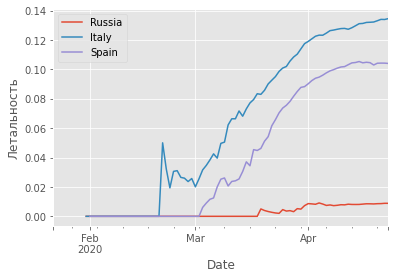

In [ ]:
#теперь посмотрим на изменение объясняемой переменной во времени, чтобы увидеть, с какими рядами мы работает

data_russia.mortality.plot(label = 'Russia')
data_italy.mortality.plot(label = 'Italy')
data_spain.mortality.plot(label = 'Spain')

plt.ylabel('Летальность')
plt.legend()

#однозначно можно утверждать, что временные ряды для Италии и Испании имеют заметный тренд, следовательно, они не будут стационарными, поэтому необходимо будет сделать обработку данных для анализа моделей АР, МА, АРМА
#однако для России сложно по графику сказать, есть ли тренд, но на этот вопрос поможет ответить тест Дики-Фуллера ниже

In [ ]:
#осталось разделить датасеты для каждой страны на трэйн и тест, где можно валидироваться
#наблюдений немного, поэтому было принято решение взять отношение трэйна к тесту 80/20
X = data_russia
train_size = int(len(X) * 0.8)
train_russia, test_russia = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_russia)))
print('Testing Observations: %d' % (len(test_russia)))

X = data_italy
train_size = int(len(X) * 0.8)
train_italy, test_italy = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_italy)))
print('Testing Observations: %d' % (len(test_italy)))

X = data_spain
train_size = int(len(X) * 0.8)
train_spain, test_spain = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_spain)))
print('Testing Observations: %d' % (len(test_spain)))

Observations: 93
Training Observations: 74
Testing Observations: 19
Observations: 93
Training Observations: 74
Testing Observations: 19
Observations: 93
Training Observations: 74
Testing Observations: 19


In [ ]:
#функция для определённого количества знаков после запятой
def toFixed(f: float, n=0):
    a, b = str(f).split('.')
    return '{}.{}{}'.format(a, b[:n], '0'*(n-len(b)))

### 2.1 Прогнозирование средним (Mean Constant Model)

Будем рассматривать три страны в разных ячейках и делать вывод для каждой из них.

Model Forecast     RMSE
0  Mean  0.00132  0.00685

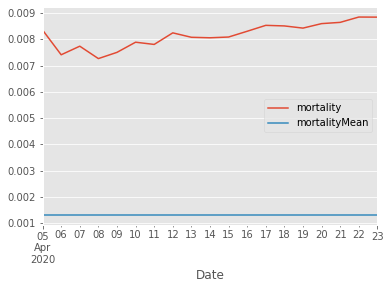

In [ ]:
#найдём среднее (mean constant) и добавим его в новую колонку датасета для России
model_mean_pred = train_russia.mortality.mean()
test_russia["mortalityMean"] = model_mean_pred
#покажем на графике предсказанные значения для теста и фактические значения на этом временном промежутке
test_russia.plot(kind="line", x="Date", y = ["mortality", "mortalityMean"])

#посчитаем метрику РМСЕ
model_mean_RMSE = RMSE(test_russia.mortalityMean, test_russia.mortality)
model_mean_RMSE

#создадим отдельную таблицу для России, где будем хранить значения метрики по всем моделям, чтобы легче было сравнить модели после оценивания последней
data_russia_Results = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
data_russia_Results.head()

#теперь добавим полученное РМСЕ В в таблицу
data_russia_Results.loc[0,"Model"] = "Mean"
data_russia_Results.loc[0,"Forecast"] = toFixed(model_mean_pred, n=5)
data_russia_Results.loc[0,"RMSE"] = toFixed(model_mean_RMSE, n=5)
data_russia_Results.head()

#как мы видим, значение РМСЕ достаточно высокое для рассматривамой статистики летальности  (оно составляет 0.00685, в то время как сама летальность в России 0.008-0.009)

Model Forecast     RMSE
0  Mean  0.04668  0.08300

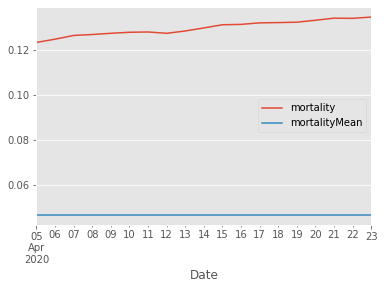

In [ ]:
#аналогичные действия проведём для Италии
model_mean_pred = train_italy.mortality.mean()
test_italy["mortalityMean"] = model_mean_pred
test_italy.plot(kind="line", x="Date", y = ["mortality", "mortalityMean"])

model_mean_RMSE = RMSE(test_italy.mortalityMean, test_italy.mortality)
model_mean_RMSE


data_italy_Results = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
data_italy_Results.head()


data_italy_Results.loc[0,"Model"] = "Mean"
data_italy_Results.loc[0,"Forecast"] = toFixed(model_mean_pred, n=5)
data_italy_Results.loc[0,"RMSE"] = toFixed(model_mean_RMSE, n=5)
data_italy_Results.head()

#мы видим, что РМСЕ, как и в случае России, очень большое относительно самих данных летальности (а РМСЕ всё равно что ошибка)

Model Forecast     RMSE
0  Mean  0.02635  0.07618

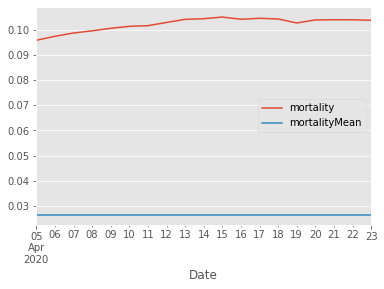

In [ ]:
#абсолютно также делаем для Испании
model_mean_pred = train_spain.mortality.mean()
test_spain["mortalityMean"] = model_mean_pred
test_spain.plot(kind="line", x="Date", y = ["mortality", "mortalityMean"])

model_mean_RMSE = RMSE(test_spain.mortalityMean, test_spain.mortality)
model_mean_RMSE


data_spain_Results = pd.DataFrame(columns = ["Model", "Forecast", "RMSE"])
data_spain_Results.head()


data_spain_Results.loc[0,"Model"] = "Mean"
data_spain_Results.loc[0,"Forecast"] = toFixed(model_mean_pred, n=5)
data_spain_Results.loc[0,"RMSE"] = toFixed(model_mean_RMSE, n=5)
data_spain_Results.head()

#как и в анализе предыдущих стран, РМСЕ при прогнозе средним слишком большое для показаний летальности 

Таким образом, по прогнозу средним во временных рядах можно сделать следующий вывод: прогноз даёт очень плохие результаты для всех трёх стран, метрика РМСЕ слишком высокая, что плохо. Впрочем, это неудивительно, ведь прогноз средним не учитывает никакие временные специфики данных и просто не может давать качественный результат.

#### 2.2 Линейная модель (Linear Trend Model) 

Теперь рассмотрим линейную модель для каждой страны в отдельности

In [ ]:
#для начала создадим новую колонку в датасете с индексом времени, потому что так будет легче работать со временем в линейной модели, чем если бы мы использовали формат даты
#при этом следует помнить, что колонку мы создаём в daya_{страна}, поэтому придётся снова разделить 3 выборки на трэйн и тест после добавления timeindex, но код для этого уже есть
data_russia.dtypes


data_russia.Date.min()

data_russia["timeIndex"] = data_russia.Date - data_russia.Date.min()

data_russia.dtypes

data_russia["timeIndex"] =  data_russia["timeIndex"]/np.timedelta64(1, 'D')

data_russia["timeIndex"] = data_russia["timeIndex"].round(0).astype(int)

data_russia.timeIndex.tail()

print(data_russia.head())

data_russia.dtypes


data_italy.Date.min()

data_italy["timeIndex"] = data_italy.Date - data_russia.Date.min()

data_italy.dtypes

data_italy["timeIndex"] =  data_italy["timeIndex"]/np.timedelta64(1, 'D')

data_italy["timeIndex"] = data_italy["timeIndex"].round(0).astype(int)

data_italy.timeIndex.tail()

print(data_italy.head())

data_italy.dtypes


data_spain.Date.min()

data_spain["timeIndex"] = data_spain.Date - data_spain.Date.min()

data_spain.dtypes

data_spain["timeIndex"] =  data_spain["timeIndex"]/np.timedelta64(1, 'D')

data_spain["timeIndex"] = data_spain["timeIndex"].round(0).astype(int)

data_spain.timeIndex.tail()

print(data_spain.head())

#теперь снова разделим на трэйн и тест

X = data_russia
train_size = int(len(X) * 0.8)
train_russia, test_russia = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_russia)))
print('Testing Observations: %d' % (len(test_russia)))

X = data_italy
train_size = int(len(X) * 0.8)
train_italy, test_italy = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_italy)))
print('Testing Observations: %d' % (len(test_italy)))

X = data_spain
train_size = int(len(X) * 0.8)
train_spain, test_spain = X.iloc[0:train_size], X.iloc[train_size:len(X)]
print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train_spain)))
print('Testing Observations: %d' % (len(test_spain)))



                 Date Country/Region  ... mortalityDiff  timeIndex
Date                                  ...                         
2020-01-22 2020-01-22         Russia  ...           nan          0
2020-01-23 2020-01-23         Russia  ...           nan          1
2020-01-24 2020-01-24         Russia  ...           nan          2
2020-01-25 2020-01-25         Russia  ...           nan          3
2020-01-26 2020-01-26         Russia  ...           nan          4

[5 rows x 14 columns]
                 Date Country/Region  ... mortalityDiff  timeIndex
Date                                  ...                         
2020-01-22 2020-01-22          Italy  ...           nan          0
2020-01-23 2020-01-23          Italy  ...           nan          1
2020-01-24 2020-01-24          Italy  ...           nan          2
2020-01-25 2020-01-25          Italy  ...           nan          3
2020-01-26 2020-01-26          Italy  ...           nan          4

[5 rows x 14 columns]
                

In [ ]:
model_linear_russia = smf.ols('mortality ~ timeIndex', data = train_russia).fit()
model_linear_italy = smf.ols('mortality ~ timeIndex', data = train_italy).fit()
model_linear_spain = smf.ols('mortality ~ timeIndex', data = train_spain).fit()

print(model_linear_russia.summary())
print(model_linear_italy.summary())
print(model_linear_spain.summary())

#каждая из построенных линейных моделей адекватна (Prob (F-statistic) меньше 0.05), коэффициент при времени (timeIndex) значим, R2 высокий, особенно это касается Италии и Испании
#что говорит о том, что в этих странах сильная временная зависимость (можно сказать, линейный тренд), сильнее, чем в России

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.515
Method:                 Least Squares   F-statistic:                     69.02
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.03e-11
Time:                        23:17:12   Log-Likelihood:                 320.76
No. Observations:                  65   AIC:                            -637.5
Df Residuals:                      63   BIC:                            -633.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0027      0.001     -5.037      0.0

In [ ]:
#теперь сделаем предсказания для трёх стран с помощью линейной модели тренда
model_linear_pred_rus = model_linear_russia.predict(test_russia)
model_linear_pred_it = model_linear_italy.predict(test_italy)
model_linear_pred_sp = model_linear_spain.predict(test_spain)

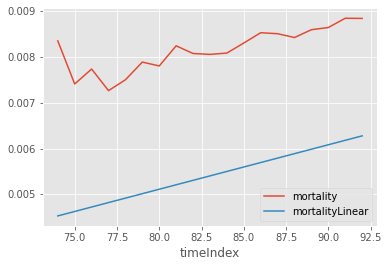

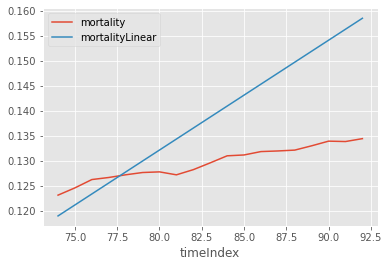

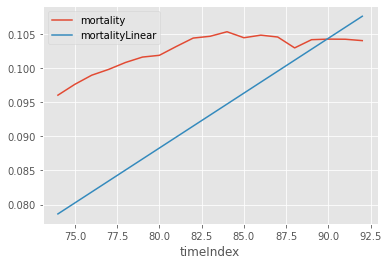

In [ ]:
#представим полученные предсказания и фактические показания теста на графиках

test_russia["mortalityLinear"] = model_linear_pred_rus
test_russia.plot(kind="line", x="timeIndex", y = ["mortality", "mortalityLinear"])

test_italy["mortalityLinear"] = model_linear_pred_it
test_italy.plot(kind="line", x="timeIndex", y = ["mortality", "mortalityLinear"])

test_spain["mortalityLinear"] = model_linear_pred_sp
test_spain.plot(kind="line", x="timeIndex", y = ["mortality", "mortalityLinear"])

#уже по графикам видно, что линейная модель тренда лучше, чем константа среднего, но при этом линия прогноза во всех трёх случаях всё ещё далека от линии с данными теста
#чтобы убедиться в сказанном, посмотрим на РМСЕ и сравним с показателями из прошлой модели

In [ ]:
model_linear_RMSE_rus = RMSE(test_russia.mortalityLinear, test_russia.mortality)
model_linear_RMSE_rus

model_linear_RMSE_it = RMSE(test_italy.mortalityLinear, test_italy.mortality)
model_linear_RMSE_it

model_linear_RMSE_sp = RMSE(test_spain.mortalityLinear, test_spain.mortality)
model_linear_RMSE_sp

0.011620273539470006

In [ ]:
data_russia_Results.loc[1,"Model"] = "Linear"
data_russia_Results.loc[1,"Forecast"] = 'Linear'
data_russia_Results.loc[1,"RMSE"] = toFixed(model_linear_RMSE_rus, n=5)
print(data_russia_Results.head())

data_italy_Results.loc[1,"Model"] = "Linear"
data_italy_Results.loc[1,"Forecast"] = 'Linear'
data_italy_Results.loc[1,"RMSE"] = toFixed(model_linear_RMSE_it, n=5)
print(data_italy_Results.head())

data_spain_Results.loc[1,"Model"] = "Linear"
data_spain_Results.loc[1,"Forecast"] = 'Linear'
data_spain_Results.loc[1,"RMSE"] = toFixed(model_linear_RMSE_sp, n=5)
print(data_spain_Results.head())

#как и следовало ожидать РМСЕ уже значительно меньше, чем был при получении прогнозов с помощью константного среднего, но всё равно оставляет желать лучшего
#такой результат логичен, потому что мы строим модель линейного тренда, а в данных кроме тренда есть и другие особенности, которая данная молель не учитывает, более того, ещё неясно, а линейный ли у нас тренд

    Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
    Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
    Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162


#### 2.3 Экспоненциальное сглаживание (Exponential smoothing)

Попробуйте так же применить Double exponential smoothing или Triple exponential smoothing.

In [ ]:
#импортируем функции для экспоненциального сглаживания, двойного экспоненциального сглаживания и тройного экспоненциального сглаживания
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.holtwinters import Holt

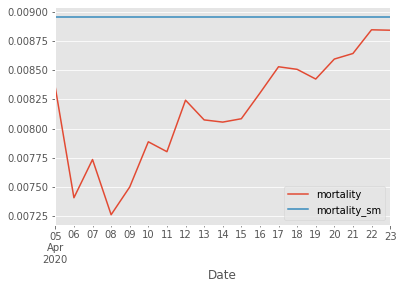

In [ ]:
#обучим модель простого экспоненциального сглаживания, сделаем предсказания на длину теста и сравним с фактическими данными теста на графике
fit_sm_rus = SimpleExpSmoothing(train_russia['mortality'].dropna()).fit()
pred_sm_rus = fit_sm_rus.forecast(len(test_russia))

test_russia["mortality_sm"] = pred_sm_rus
test_russia.plot(kind="line", x="Date", y = ["mortality", "mortality_sm"])
#видим, что предсказание совсем не похоже на данные, но, возможно, РМСЕ будет меньше, потому что линия с предсказаниями лежит ближе к данным
#вообще такой график был ожидаем, потому что одиночное сглаживание не учитывает ни тренда, ни сезонности

In [ ]:
#найдём RMSE и добавим его в таблицу с результатами по России
model_sm_RMSE_rus = RMSE(test_russia.mortality_sm, test_russia.mortality)
data_russia_Results.loc[7,"Model"] = "SM"
data_russia_Results.loc[7,"Forecast"] = 'SM'
data_russia_Results.loc[7,"RMSE"] = toFixed(model_sm_RMSE_rus, n=5)
data_russia_Results.head()

#несмотря на то, что сглаживание не учитывает тренд, оно всё равно лучше, чем константная и линейная модели

Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091

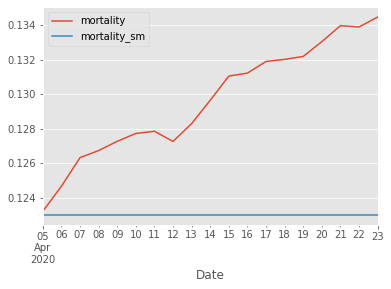

In [ ]:
#теперь проведём аналогичный анализ с данными для Италии
fit_sm_it = SimpleExpSmoothing(train_italy['mortality'].dropna()).fit()
pred_sm_it = fit_sm_it.forecast(len(test_italy))

test_italy["mortality_sm"] = pred_sm_it
test_italy.plot(kind="line", x="Date", y = ["mortality", "mortality_sm"])

#расположение графиков похоже на ситуацию с Россией

In [ ]:
# RMSE
model_sm_RMSE_it = RMSE(test_italy.mortality_sm, test_italy.mortality)
data_italy_Results.loc[7,"Model"] = "SM"
data_italy_Results.loc[7,"Forecast"] = 'SM'
data_italy_Results.loc[7,"RMSE"] = toFixed(model_sm_RMSE_it, n=5)
data_italy_Results.head()

#качество модели экспоненциального сглаживания лучше, чем в предыдущих моделях анализа для Италии

Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737

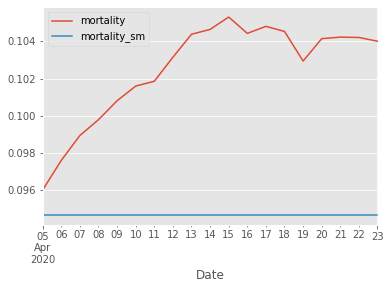

In [ ]:
#теперь проделаем все те же действия, что и выше, с Испанией
fit_sm_sp = SimpleExpSmoothing(train_spain['mortality'].dropna()).fit(optimized=True)
pred_sm_sp = fit_sm_sp.forecast(len(test_spain))

test_spain["mortality_sm"] = pred_sm_sp
test_spain.plot(kind="line", x="Date", y = ["mortality", "mortality_sm"])

In [ ]:
#находим RMSE для Испании в модели с экспоненциальным сглаживанием и добавляем его в таблицу для сравнения
model_sm_RMSE_sp = RMSE(test_spain.mortality_sm, test_spain.mortality)
data_spain_Results.loc[7,"Model"] = "SM"
data_spain_Results.loc[7,"Forecast"] = 'SM'
data_spain_Results.loc[7,"RMSE"] = toFixed(model_sm_RMSE_sp, n=5)
data_spain_Results.head()

#так же, как и для других стран, экспоненциальное сглаживание лучше, чем другие модели

Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162
7      SM       SM  0.00823

Теперь посмотрим на двойное сглаживание, которое явно добавляет поддержку трендов в одномерном временном ряду

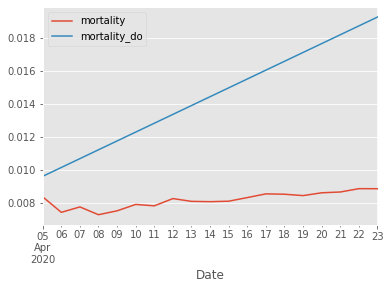

In [ ]:
#рассмотрим Россию
#была выбрана аддитивная тенденция (exponential=False)
fit_do_rus = Holt(train_russia['mortality'].dropna()).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
pred_do_rus = fit_do_rus.forecast(len(test_russia))

test_russia["mortality_do"] = pred_do_rus
test_russia.plot(kind="line", x="Date", y = ["mortality", "mortality_do"])

#по графику соотношения фактических данных и предсказаний можно сделать предположение, что двойное сглаживание лучше работает, скорее всего, это связано с учётом тренда

In [ ]:
#найдём RMSE модели двойного сглаживнаия для России
model_do_RMSE_rus = RMSE(test_russia.mortality_do, test_russia.mortality)
data_russia_Results.loc[8,"Model"] = "DO"
data_russia_Results.loc[8,"Forecast"] = 'DO'
data_russia_Results.loc[8,"RMSE"] = toFixed(model_do_RMSE_rus, n=5)
data_russia_Results.head()

#несмотря на предположение, что двойное сглаживание будет работать лучше для предсказания, оно работает хуже

Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091
8      DO       DO  0.00676

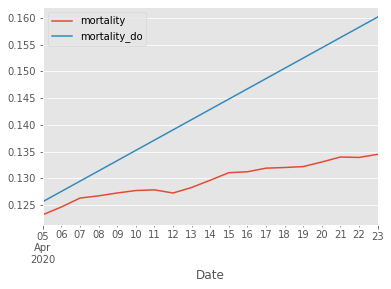

In [ ]:
#теперь повторим все действия для Италии
fit_do_it = Holt(train_italy['mortality'].dropna()).fit(optimized=True)
pred_do_it = fit_do_it.forecast(len(test_italy))

test_italy["mortality_do"] = pred_do_it
test_italy.plot(kind="line", x="Date", y = ["mortality", "mortality_do"])

In [ ]:
#найдём RMSE модели двойного сглаживания для Италии 
model_do_RMSE_it = RMSE(test_italy.mortality_do, test_italy.mortality)
data_italy_Results.loc[8,"Model"] = "DO"
data_italy_Results.loc[8,"Forecast"] = 'DO'
data_italy_Results.loc[8,"RMSE"] = toFixed(model_do_RMSE_it, n=5)
data_italy_Results.head()

#как и в случае с Россией двойное сглаживание для Италии работает хуже, чем просто экспоненциальное сглаживание
#более того, оно работает даже хуже, чем линейная модель

Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737
8      DO       DO  0.01516

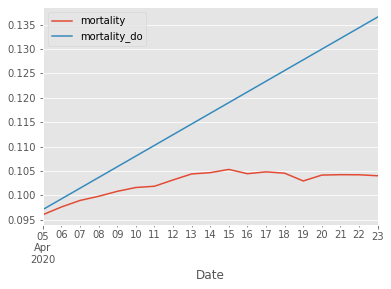

In [ ]:
#теперь посмотрим на Испанию
fit_do_sp = Holt(train_spain['mortality'].dropna()).fit(optimized=True)
pred_do_sp = fit_do_sp.forecast(len(test_spain))
test_spain["mortality_do"] = pred_do_sp
test_spain.plot(kind="line", x="Date", y = ["mortality", "mortality_do"])

In [ ]:
#найдём RMSE для Испании и сравним с результатами, полученными при анализе других моделей
model_do_RMSE_sp = RMSE(test_spain.mortality_do, test_spain.mortality)
data_spain_Results.loc[8,"Model"] = "DO"
data_spain_Results.loc[8,"Forecast"] = 'DO'
data_spain_Results.loc[8,"RMSE"] = toFixed(model_do_RMSE_sp, n=5)
data_spain_Results.head()

#такая же ситуация, как и с Италией: двойное сглаживание работает хуже, чем линейная модель все предыдущие модели

Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162
7      SM       SM  0.00823
8      DO       DO  0.01746

Теперь посмотрим на тройное сглаживание, которое учитывает сезонность в данных

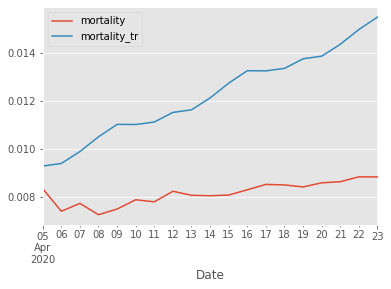

In [ ]:
#построим  модель тройного сглаживания на данных по России, построим предсказания на длину теста и  посмотрим на график сравнения фактических данных и предсказаний
fit_tr_rus = ExponentialSmoothing(train_russia['mortality'].dropna(), seasonal_periods = 7, trend='add', seasonal='add').fit()
pred_tr_rus = fit_tr_rus.forecast(len(test_russia))

test_russia["mortality_tr"] = pred_tr_rus
test_russia.plot(kind="line", x="Date", y = ["mortality", "mortality_tr"])

In [ ]:
#найдём RMSE и сравним с другими моделями
model_tr_RMSE_rus = RMSE(test_russia.mortality_tr.values, test_russia.mortality.values)
data_russia_Results.loc[9,"Model"] = "TR"
data_russia_Results.loc[9,"Forecast"] = 'TR'
data_russia_Results.loc[9,"RMSE"] = toFixed(model_tr_RMSE_rus, n=5)
data_russia_Results.head()

#модель тройного сглаживания показывает результат несколько лучше, чем двойное сглаживание, но значение РМСЕ нельзя назвать показательным

Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091
8      DO       DO  0.00676
9      TR       TR  0.00433

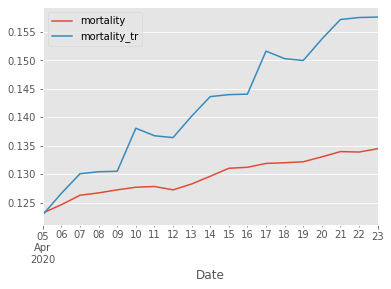

In [ ]:
#теперь повторим все те же действия для Италии
fit_tr_it = ExponentialSmoothing(train_italy['mortality'].dropna(), seasonal_periods = 7, trend='add', seasonal='add').fit()
pred_tr_it = fit_tr_it.forecast(len(test_italy))

test_italy["mortality_tr"] = pred_tr_it
test_italy.plot(kind="line", x="Date", y = ["mortality", "mortality_tr"])

In [ ]:
# RMSE
model_tr_RMSE_it = RMSE(test_italy.mortality_tr, test_italy.mortality)
data_italy_Results.loc[9,"Model"] = "TR"
data_italy_Results.loc[9,"Forecast"] = 'TR'
data_italy_Results.loc[9,"RMSE"] = toFixed(model_tr_RMSE_it, n=5)
data_italy_Results.head()

#для Италии модель тройного сглаживания работает лучше, чем двойного, но при этом хуже, чем просто линейная модель тренда

Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737
8      DO       DO  0.01516
9      TR       TR  0.01466

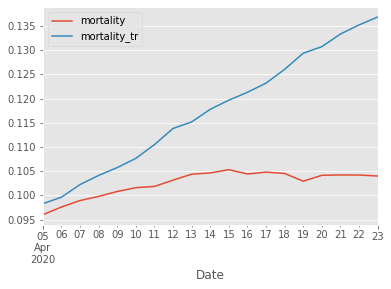

In [ ]:
#повторим все те же действия для Испании
fit_tr_sp = ExponentialSmoothing(train_spain['mortality'].dropna(), seasonal_periods = 7, trend='add', seasonal='add').fit()
pred_tr_sp = fit_tr_sp.forecast(len(test_spain))

test_spain["mortality_tr"] = pred_tr_sp
test_spain.plot(kind="line", x="Date", y = ["mortality", "mortality_tr"])

In [ ]:
# RMSE
model_tr_RMSE_sp = RMSE(test_spain.mortality_tr, test_spain.mortality)
data_spain_Results.loc[9,"Model"] = "TR"
data_spain_Results.loc[9,"Forecast"] = 'TR'
data_spain_Results.loc[9,"RMSE"] = toFixed(model_tr_RMSE_sp, n=5)
data_spain_Results.head()

#модель тройного сглаживания работает примерно так же, как модель двойного сглаживания

Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162
7      SM       SM  0.00823
8      DO       DO  0.01746
9      TR       TR  0.01799

Таким образом, можно сделать вывод, что из всех моделей экспоненциального сглаживания лучше работает простое сглаживание для всех трёх стран.

#### 2.4 Скользящее среднее (MA - Moving average)

Поэксперементируйте с гиперпараметрами модели.

Для того чтобы работать с моделями MA, AR и ARMA необходимо для начала проверить, а является ли временной ряд стационарным. Если он не является стационарным, то необходимо попытаться сделать его стационарным каким-либо из следующих способов: дифференцирование, вычитание тренда, преобразование Бокса-Кокса, логарифмирование. При анализе в этой др было принято решение использовать дифференцирование (также пробовала вычитание тренда, но результаты очень похожи на просто Linear trend)/

In [ ]:
#Почему стационарность так важна?
#По стационарному ряду просто строить прогноз, так как мы полагаем, что его будущие статистические характеристики не будут отличаться от наблюдаемых текущих. 
#Большинство моделей временных рядов так или иначе моделируют и предсказывают эти характеристики (например, матожидание или дисперсию), поэтому в случае нестационарности исходного ряда предсказания окажутся неверными. 
#К сожалению, большинство временных рядов, с которыми приходится сталкиваться за пределыми учебных материалов, стационарными не являются, но с этим можно (и нужно) бороться.

In [ ]:
#посмотрим, стаицонарен ли временной ряд по Росиии

test = sm.tsa.adfuller(data_russia.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#ряд не стационарен, попробуем вычесть тренд

adf:  -0.14763753909548738
p-value:  0.9444820421930743
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
Есть единичные корни, ряд не стационарен


In [ ]:
#проделаем всё то же самое для Италии и Испании

test = sm.tsa.adfuller(data_italy.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -0.2593582806412489
p-value:  0.9310664368182195
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Есть единичные корни, ряд не стационарен


In [ ]:
test = sm.tsa.adfuller(data_spain.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -0.3443200811001546
p-value:  0.9189885056673741
Critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
Есть единичные корни, ряд не стационарен


In [ ]:
#Теперь будем работать отдельно со всеми странами и начнём с России

#для начала посмотрим, какое нужно взять d

#попробуем взять 1 разницу и посмотрим, стал ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_russia.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -3.342209161325432
p-value:  0.013093973296153926
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
Единичных корней нет, ряд стационарен


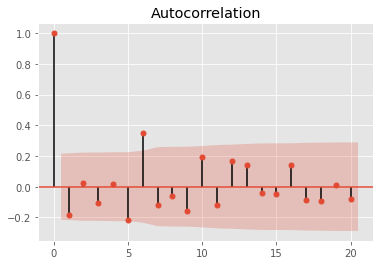

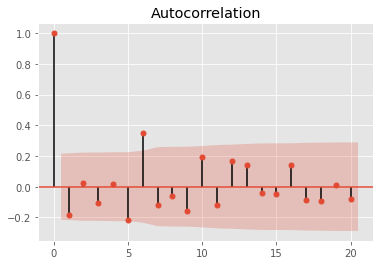

In [ ]:
#Автокорреляционная функия может сказать порядок МА части, q, которые нужны, чтобы устранить автокорреляцию в стационарном ряду

plot_acf(data_russia['mortality'].diff().dropna())

#За начальное приближение можно взять лаг=1

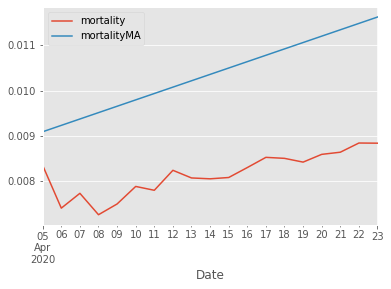

In [ ]:
#импортируем модель АРИМА
from statsmodels.tsa.arima_model import ARIMA

# остановимся на модели ARMA(0, 1, 1), потому что при увеличении q RMSE становится только больше, что плохо
mod_rus = ARIMA(train_russia['mortality'].dropna(), order=(0, 1, 1))
res_rus = mod_rus.fit()
model_ma_pred_rus = res_rus.forecast(len(test_russia))[0]
test_russia["mortalityMA"] = model_ma_pred_rus
test_russia.plot(x="Date", y = ["mortality", "mortalityMA" ])

In [ ]:
#найдём RMSE для России и добавим в таблицу
model_ma_RMSE = RMSE(test_russia.mortalityMA, test_russia.mortality)
data_russia_Results.loc[3,"Model"] = "MA"
data_russia_Results.loc[3,"Forecast"] = 'MA'
data_russia_Results.loc[3,"RMSE"] = toFixed(model_ma_RMSE, n=5)
data_russia_Results

#MA, построенная на дифференцированном стационарном ряде из последовательностей работает достаточно прилично и показывает один из лучших результатов, проверим так ли это для Испании и Италии

Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091
8      DO       DO  0.00676
9      TR       TR  0.00433
3      MA       MA  0.00224

In [ ]:
##теперь повторим все те же действия для Италии

#для начала посмотрим, какое нужно взять d

#попробуем взять 1 разницу и посмотрим, стали ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_italy.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -9.366661940387875
p-value:  7.56818438166459e-16
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Единичных корней нет, ряд стационарен


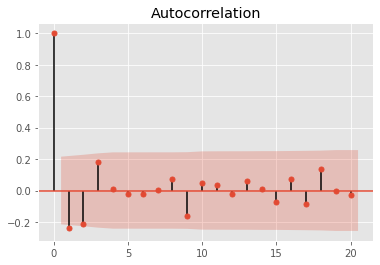

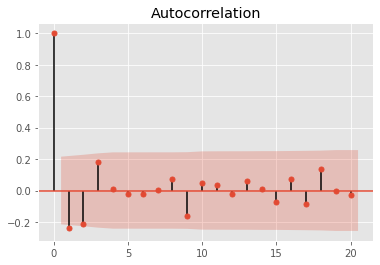

In [ ]:
plot_acf(data_italy['mortality'].diff().dropna())

#За начальное приближение q можно взять 1/2

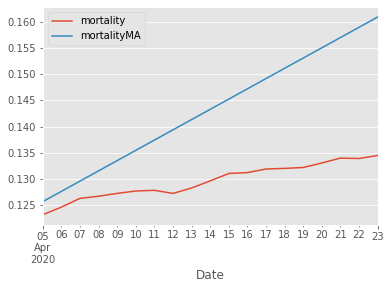

In [ ]:
#Модель MA(0, 1, 1) model работает лучше чем (0, 1, 2) по РМСЕ
mod_it = ARIMA(train_italy['mortality'].dropna(), order=(0, 1, 1))
res_it  = mod_it.fit()
model_ma_pred = res_it.forecast(len(test_italy))[0]
test_italy["mortalityMA"] = model_ma_pred
test_italy.plot(x="Date", y = ["mortality", "mortalityMA" ])

In [ ]:
# RMSE
model_ma_RMSE_it = RMSE(test_italy.mortalityMA, test_italy.mortality)
data_italy_Results.loc[3,"Model"] = "MA"
data_italy_Results.loc[3,"Forecast"] = 'MA'
data_italy_Results.loc[3,"RMSE"] = toFixed(model_ma_RMSE_it, n=5)
data_italy_Results

#для Италии продифференцированный ряд с MA работает не очень хорошо, возможно, что нужно брать и часть AR и тогда прогноз будет более точным

Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737
8      DO       DO  0.01516
9      TR       TR  0.01466
3      MA       MA  0.01559

In [ ]:
##теперь повторим все те же действия для Испании

#для начала посмотрим, какое нужно взять d

#попробуем взять 1 разницу и посмотрим, стал ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_spain.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -2.9374444779647955
p-value:  0.04116377706134384
Critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
Единичных корней нет, ряд стационарен


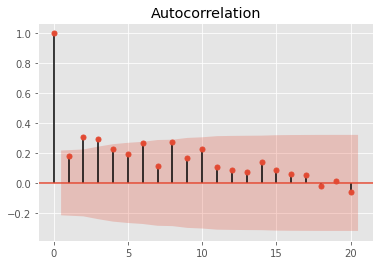

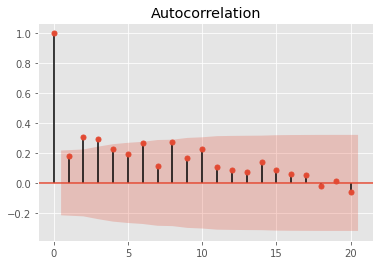

In [ ]:
plot_acf(data_spain['mortality'].diff().dropna())

#за начальное приближение возьём q=1

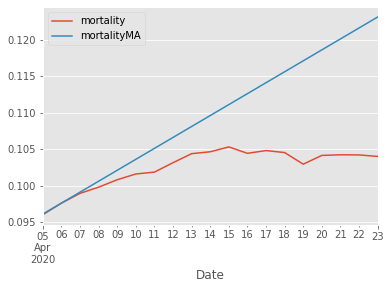

In [ ]:
mod_sp = ARIMA(train_spain['mortality'].dropna(), order=(0, 1, 1))
res_sp = mod_sp.fit()
model_ma_pred_sp = res_sp.forecast(len(test_spain))[0]
test_spain["mortalityMA"] = model_ma_pred_sp
test_spain.plot(x="Date", y = ["mortality", "mortalityMA" ])

In [ ]:
# RMSE
model_ma_RMSE_sp = RMSE(test_spain.mortalityMA, test_spain.mortality)
data_spain_Results.loc[3,"Model"] = "MA"
data_spain_Results.loc[3,"Forecast"] = 'MA'
data_spain_Results.loc[3,"RMSE"] = toFixed(model_ma_RMSE_sp, n=5)
data_spain_Results

#видим, что для Испании такой ряд работает очень хорошо, как и для России, и метрика РМСЕ достаточно низкая

Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162
7      SM       SM  0.00823
8      DO       DO  0.01746
9      TR       TR  0.01799
3      MA       MA  0.00947

Таким образом, можем сделать вывод, что, во-первых, при подборе модели MA необходимо нестационарный ряд превратить в стационарный. В решении был рассмотрен способ - дифференцирование ряда. В зависимости от страны рассматриваемая модель работала то хорошо, то плохо: в случае России она работала наравне с лучшими моделями, а в случае Италии, к примеру, хуже всех.

#### 2.5 Авторегрессионная модель (AR - Autoregressive model)

Поэксперементируйте с гиперпараметрами модели.

Для модели AR будем действовать по такой же стратегии. Мы уже знаем, что ряд необходимо продифференцировать, чтобы превратить его в стационарный, и только потом подбирать параметр p.

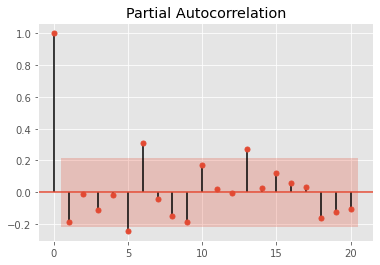

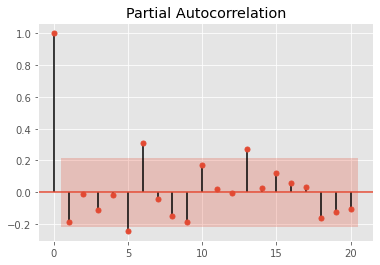

In [ ]:
#для начала рассмотрим Россию и учтём, что d уже была подобрана выше

#в прошлой задаче было выявлено, что ряд становится стационарным при d=1
#попробуем подобрать p = ? для модели AR

# Частичная автокорреляционная функция может сказать порядок AR части, который необходим для удаления авторегрессии в стационарных рядах.

plot_pacf(data_russia['mortality'].diff().dropna())

#За начально приближение возьмём p = 1

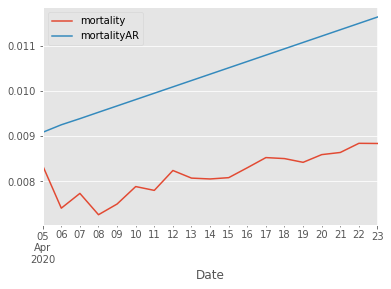

In [ ]:
#были рассмотрены несколько случаев с гиперпараметром p, но лучший РМСЕ показал p=1, поэтому отразим его в таблице
mod_rus = ARIMA(train_russia['mortality'].dropna(), order=(1, 1, 0))
res_rus = mod_rus.fit()
model_ar_pred_rus = res_rus_1.forecast(len(test_russia))[0]
test_russia["mortalityAR"] = model_ar_pred_rus
test_russia.plot(x="Date", y = ["mortality", "mortalityAR" ])

In [ ]:
# RMSE
model_ar_RMSE = RMSE(test_russia.mortalityAR, test_russia.mortality)
data_russia_Results.loc[4,"Model"] = "AR"
data_russia_Results.loc[4,"Forecast"] = 'AR'
data_russia_Results.loc[4,"RMSE"] = toFixed(model_ar_RMSE, n=5)
data_russia_Results

#результат похож на результаты МА с дифференцированием: один из самых лучших в таблице сравнения моделей для России

Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091
8      DO       DO  0.00676
9      TR       TR  0.00433
3      MA       MA  0.00224
4      AR       AR  0.00225

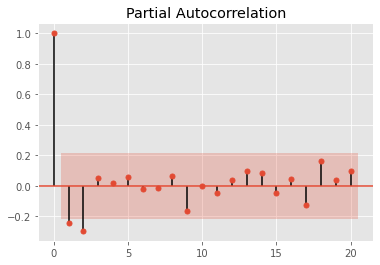

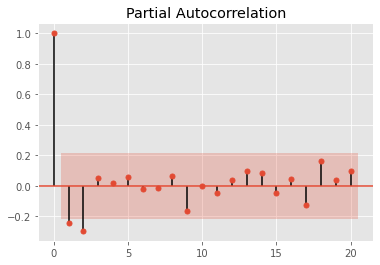

In [ ]:
#теперь посмотрим на Италию

#для начала определим потенциальную степень p

plot_pacf(data_italy['mortality'].diff().dropna())

#За начальное приближение можно взять p = 1 + можно попробовать p=2

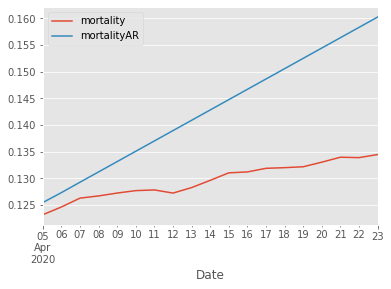

In [ ]:
#так же, как и в предыдущем анализе, было определено методом подбора, что p=1 показывает лучший результат, отразим это в таблице и на графике
mod_it = ARIMA(train_italy['mortality'].dropna(), order=(1, 1, 0))
res_ar = mod_it.fit()
model_ar_pred_it = res_ar.forecast(len(test_italy))[0]
test_italy["mortalityAR"] = model_ar_pred_it
test_italy.plot(x="Date", y = ["mortality", "mortalityAR" ])

In [ ]:
# RMSE
model_ar_RMSE_it = RMSE(test_italy.mortalityAR, test_italy.mortality)
data_italy_Results.loc[4,"Model"] = "AR"
data_italy_Results.loc[4,"Forecast"] = 'AR'
data_italy_Results.loc[4,"RMSE"] = toFixed(model_ar_RMSE_it, n=5)
data_italy_Results

#результат получается не из лучших, как и в MA для Италии

Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737
8      DO       DO  0.01516
9      TR       TR  0.01466
3      MA       MA  0.01559
4      AR       AR  0.01517

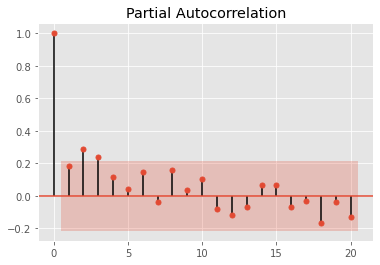

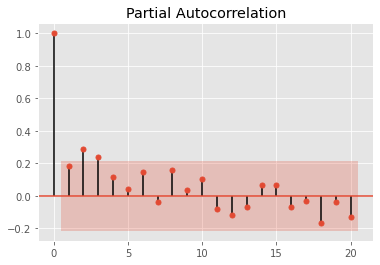

In [ ]:
#теперь повторим все те же действия для Испании

plot_pacf(data_spain['mortality'].diff().dropna())

#за начальное приближение можно взять p=1, 2, 3

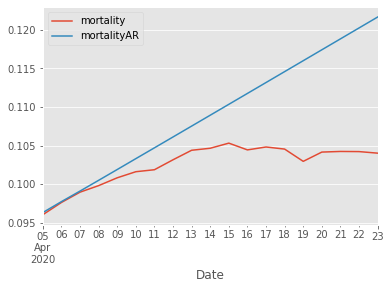

In [ ]:
#получается, что при подборе p была закономерность, что чем больше p до какого-то момента, тем лучше качество, поэтому пришлось поэкспериментировать и выйти за начальное приближение, определённое в предыдущей ячейке

mod_sp = ARIMA(train_spain['mortality'].dropna(), order=(5, 1, 0))
res_sp = mod_sp.fit()
model_ar_pred_sp = res_sp.forecast(len(test_spain))[0]
test_spain["mortalityAR"] = model_ar_pred_sp
test_spain.plot(x="Date", y = ["mortality", "mortalityAR" ])

In [ ]:
# RMSE
model_ar_RMSE_sp = RMSE(test_spain.mortalityAR, test_spain.mortality)
data_spain_Results.loc[4,"Model"] = "AR"
data_spain_Results.loc[4,"Forecast"] = 'AR'
data_spain_Results.loc[4,"RMSE"] = toFixed(model_ar_RMSE_sp, n=5)
data_spain_Results

#получается, как и в случае России, достойный результат РМСЕ, один из лучших

Model Forecast     RMSE
0    Mean  0.02635  0.07618
1  Linear   Linear  0.01162
7      SM       SM  0.00823
8      DO       DO  0.01746
9      TR       TR  0.01799
3      MA       MA  0.00947
4      AR       AR  0.00867

Таким образом, можно сделать вывод, что модель AR тоже работает неплохо в зависимости от страны. В Испании и Италии лучше, чем МА, при этом в Италии так же плохо как МА по сравнению с другими моделями. В России AR работает примерно так же, как и MA. 

В целом, результаты по моделям МА и AR хорошие, но посмотрим, можно ли их улучшить, если соединить в ARMA или ARIMA

#### 2.6 ARMA

Вообще, строго говоря, временные ряды по COVID-19 являются нестационарными, поэтому просто ARMA без дифференцирования (не ARIMA) использовать нельзя, потому что это может привести к неверным результатам. Посмотрим, что будет, если нестационарные ряды не дифференцировать, то есть не приводить к стационарному виду.

Выше уже были подобраны начальные значения для p и q с помощью автокорреляционной и частичной автокорреляционной функции. Попробуем поэкспериментировать с ARMA без дифференцирования

In [ ]:
#посмотрим на Россию

for i in range(0, 5):
  for j in range(0, 5):
    try:
      mod_rus = ARMA(train_russia['mortality'].dropna(), order = (i, j))
      res_rus = mod_rus.fit()
    except ValueError:
      print("ARMA не подходит! Нужно продифференцировать" , i, j)


ARMA не подходит! Нужно продифференцировать 1 1
ARMA не подходит! Нужно продифференцировать 1 2
ARMA не подходит! Нужно продифференцировать 1 3
ARMA не подходит! Нужно продифференцировать 1 4
ARMA не подходит! Нужно продифференцировать 2 1
ARMA не подходит! Нужно продифференцировать 2 2
ARMA не подходит! Нужно продифференцировать 2 3
ARMA не подходит! Нужно продифференцировать 2 4
ARMA не подходит! Нужно продифференцировать 3 1
ARMA не подходит! Нужно продифференцировать 3 2
ARMA не подходит! Нужно продифференцировать 3 3
ARMA не подходит! Нужно продифференцировать 3 4
ARMA не подходит! Нужно продифференцировать 4 1
ARMA не подходит! Нужно продифференцировать 4 2
ARMA не подходит! Нужно продифференцировать 4 3
ARMA не подходит! Нужно продифференцировать 4 4


In [ ]:
#посмотрим на Италию

for i in range(0, 5):
  for j in range(0, 5):
    try:
      mod_it = ARMA(train_italy['mortality'].dropna(), order = (i, j))
      res_it = mod_it.fit()
    except ValueError:
      print("ARMA не подходит! Нужно продифференцировать" , i, j)

ARMA не подходит! Нужно продифференцировать 0 4
ARMA не подходит! Нужно продифференцировать 1 1
ARMA не подходит! Нужно продифференцировать 1 2
ARMA не подходит! Нужно продифференцировать 1 3
ARMA не подходит! Нужно продифференцировать 1 4
ARMA не подходит! Нужно продифференцировать 2 1
ARMA не подходит! Нужно продифференцировать 2 2
ARMA не подходит! Нужно продифференцировать 2 3
ARMA не подходит! Нужно продифференцировать 2 4
ARMA не подходит! Нужно продифференцировать 3 1
ARMA не подходит! Нужно продифференцировать 3 2
ARMA не подходит! Нужно продифференцировать 3 3
ARMA не подходит! Нужно продифференцировать 3 4
ARMA не подходит! Нужно продифференцировать 4 1
ARMA не подходит! Нужно продифференцировать 4 2
ARMA не подходит! Нужно продифференцировать 4 3
ARMA не подходит! Нужно продифференцировать 4 4


In [ ]:
#посмотрим на Испанию

for i in range(0, 5):
  for j in range(0, 5):
    try:
      mod_it = ARMA(train_spain['mortality'].dropna(), order = (i, j))
      res_it = mod_it.fit()
    except ValueError:
      print("ARMA не подходит! Нужно продифференцировать" , i, j)
    except LinAlgError:
      print("ARMA не подходит! Нужно продифференцировать" , i, j)

ARMA не подходит! Нужно продифференцировать 0 2
ARMA не подходит! Нужно продифференцировать 0 4
ARMA не подходит! Нужно продифференцировать 1 1
ARMA не подходит! Нужно продифференцировать 1 2
ARMA не подходит! Нужно продифференцировать 1 3
ARMA не подходит! Нужно продифференцировать 1 4
ARMA не подходит! Нужно продифференцировать 2 1
ARMA не подходит! Нужно продифференцировать 2 2
ARMA не подходит! Нужно продифференцировать 2 3
ARMA не подходит! Нужно продифференцировать 2 4
ARMA не подходит! Нужно продифференцировать 3 2
ARMA не подходит! Нужно продифференцировать 3 3
ARMA не подходит! Нужно продифференцировать 3 4
ARMA не подходит! Нужно продифференцировать 4 1
ARMA не подходит! Нужно продифференцировать 4 3
ARMA не подходит! Нужно продифференцировать 4 4


Таким образом, предположение о том, что ARMA не работает, потому что временные ряды по вирусу нестационарны, оправдывается и необходимо продифференцировать их, чтобы воспользоваться моделью ARMA, другими словами, построить модель ARIMA, то есть пришло время перейти к следующему пункту.

#### 2.7 Интегрированная модель авторегрессии — скользящего среднего (Auto Regressive Integrated Moving Average)

Теперь попробуем применить модель АРИМА, которая с помощью дифференцирования помогает бороться с нестационарностью временного ряда.

In [ ]:
#для начала импортируем модель АРИМА
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
#воспользуемся уже написанным выше кодом для напоминания, что временной ряд по России, действительно, нестационарный
test = sm.tsa.adfuller(data_russia.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -0.14763753909548738
p-value:  0.9444820421930743
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
Есть единичные корни, ряд не стационарен


In [ ]:
#теперь попробуем взять 1 разницу и посмотрим, стали ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_russia.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -3.342209161325432
p-value:  0.013093973296153926
Critical values:  {'1%': -3.518281134660583, '5%': -2.899878185191432, '10%': -2.5872229937594873}
Единичных корней нет, ряд стационарен


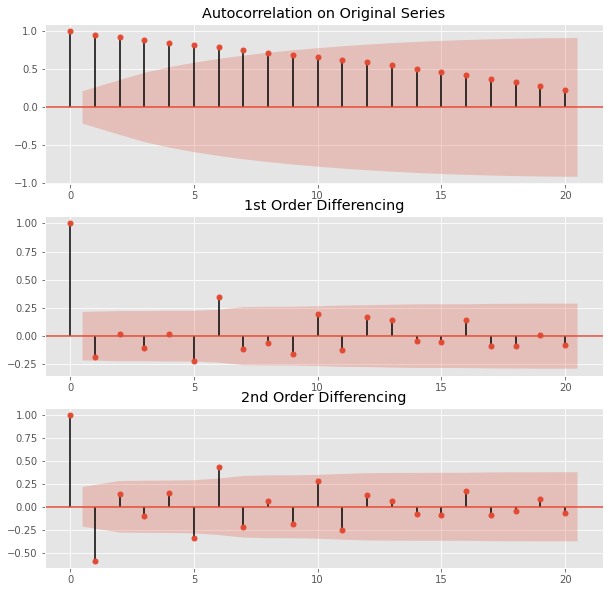

In [ ]:
#в том, что достаточно брать 1 разницу, можно и убедиться, проанализировав автокорреляционные функции для разниц

#We start by finding out the order of differencing, d, using auto correlation:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(data_russia['mortality'].dropna(), ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(data_russia['mortality'].diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(data_russia['mortality'].diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

#The timeseries is stationary at d = 1 where only the first lag is above the significance level. If your series is slightly under differenced, try adding an additional AR term and if it is slightly over-differenced, maybe add an MA


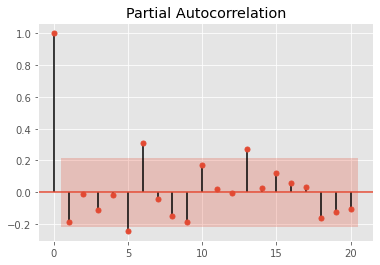

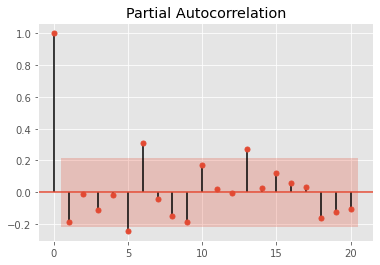

In [ ]:
#Knowing we should difference once, we go on to find out the order of AR, p. We get it by counting the number of lags above the level of significance in partial autocorrelation

plot_pacf(data_russia['mortality'].diff().dropna(), lags=20)

#The first lag is the only one vastly above the signicance level and so p = 1.

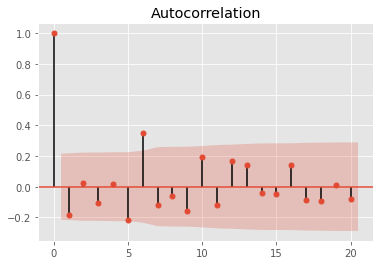

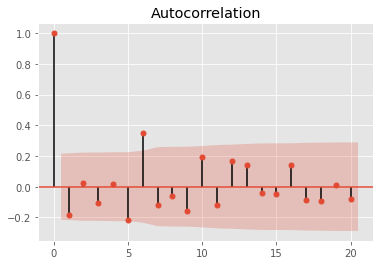

In [ ]:
#The autocorrelation function can tell the order of MA terms, q, needed to remove autocorrelation in the stationary series.

plot_acf(data_russia['mortality'].diff().dropna())

#One lag can be found above the significance level and thus q = 1.

In [ ]:
#теперь попробуем обучить модель с подобранными на глаз параметрами

model = ARIMA(train_russia['mortality'].dropna(), order=(1, 1, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mortality   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 362.525
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 04 May 2020   AIC                           -717.049
Time:                        23:17:28   BIC                           -708.414
Sample:                    02-01-2020   HQIC                          -713.647
                         - 04-04-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0001   7.83e-05      1.790      0.078   -1.33e-05       0.000
ar.L1.D.mortality     0.2543      0.512      0.496      0.621      -0.749       1.258
ma.L1.D.mortality    -0.4471      0.473     -0.945      0.348      -1.375       0.480
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.9331           +0.0000j            3.9331            0.0000
MA.1            2.2364           +0.0000j            2.2364            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
#для сравнения можно взять порядок дифференцирования равный 2 и посмотреть, как поменяется штрафной критерий AIC (чем меньше критерий, тем лучше)
model_try = ARIMA(train_russia['mortality'].dropna(), order=(1, 2, 1))
results_try = model_try.fit()
results_try.summary()

#видим, что в предыдущем случае AIC меньше, значит, модель (1, 1, 1) лучше

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.mortality   No. Observations:                   63
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 356.023
Method:                       css-mle   S.D. of innovations              0.001
Date:                Mon, 04 May 2020   AIC                           -704.046
Time:                        23:17:28   BIC                           -695.473
Sample:                    02-02-2020   HQIC                          -700.674
                         - 04-04-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               9.495e-06   4.56e-06      2.083      0.041    5.63e-07    1.84e-05
ar.L1.D2.mortality    -0.2275      0.122     -1.861      0.068      -0.467       0.012
ma.L1.D2.mortality    -1.0000      0.047    -21.141      0.000      -1.093      -0.907
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -4.3958           +0.0000j            4.3958            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

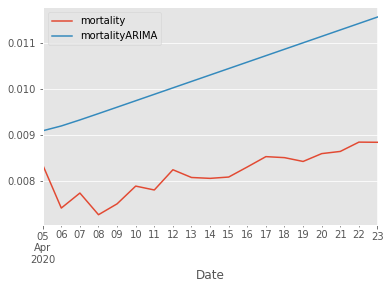

In [ ]:
model_arima_pred_rus = results.forecast(len(test_russia))[0]
test_russia["mortalityARIMA"] = model_arima_pred_rus
test_russia.plot(x="Date", y = ["mortality", "mortalityARIMA"])

In [ ]:
#теперь посчитаем RMSE для выбранной модели ARIMA (1, 1, 1)
model_arima_RMSE = RMSE(test_russia.mortalityARIMA, test_russia.mortality)
data_russia_Results.loc[6,"Model"] = "ARIMA"
data_russia_Results.loc[6,"Forecast"] = 'ARIMA (1, 1, 1)'
data_russia_Results.loc[6,"RMSE"] = toFixed(model_arima_RMSE, n=5)
data_russia_Results

#что и следовало ожидать, результат оказался лучшим, чем те, что были получены в моделях до этого (за исключением экспоненциального сглаживания)

Model         Forecast     RMSE
0    Mean          0.00132  0.00685
1  Linear           Linear  0.00277
7      SM               SM  0.00091
8      DO               DO  0.00676
9      TR               TR  0.00433
3      MA               MA  0.00224
4      AR               AR  0.00225
6   ARIMA  ARIMA (1, 1, 1)  0.00219

In [ ]:
#теперь проделаем все те же действия для Италии

#воспользуемся уже написанным выше кодом для напоминания, что временной ряд по Италии, действительно, нестационарный
test = sm.tsa.adfuller(data_italy.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -0.2593582806412489
p-value:  0.9310664368182195
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Есть единичные корни, ряд не стационарен


In [ ]:
#теперь попробуем взять 1 разницу и посмотрим, стали ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_italy.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -9.366661940387875
p-value:  7.56818438166459e-16
Critical values:  {'1%': -3.5137900174243235, '5%': -2.8979433868293945, '10%': -2.5861907285474777}
Единичных корней нет, ряд стационарен


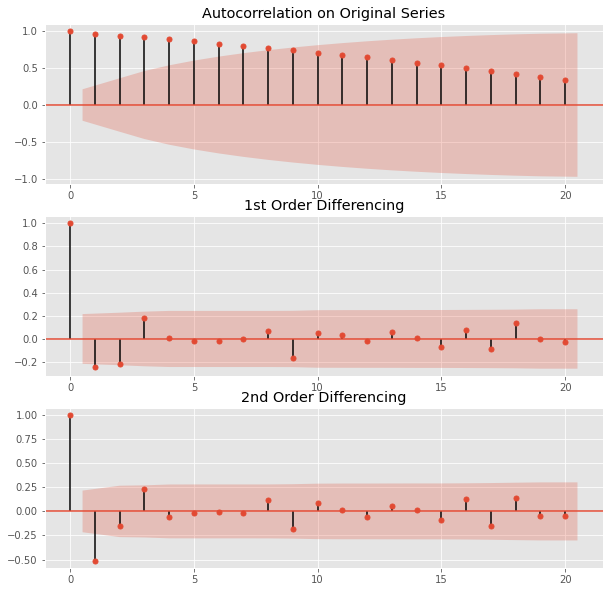

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(data_italy['mortality'].dropna(), ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(data_italy['mortality'].diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(data_italy['mortality'].diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

#ситуация похожая на Россию, но плохо видно, попадает ли 2ой лаг на графике автокорреляции 1ой разницы, поэтому лучше рассмотреть две модели: с d=1 и d=2

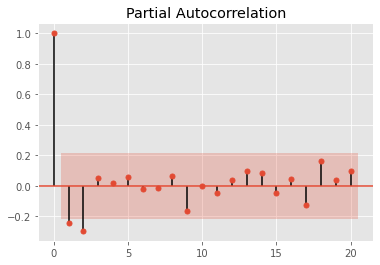

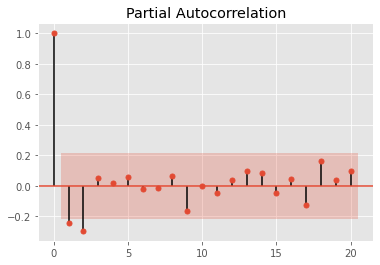

In [ ]:
#Knowing we should difference once, we go on to find out the order of AR, p. We get it by counting the number of lags above the level of significance in partial autocorrelation

plot_pacf(data_italy['mortality'].diff().dropna(), lags=20)

#The first lag is the only one vastly above the signicance level and so p = 2 or p = 1.

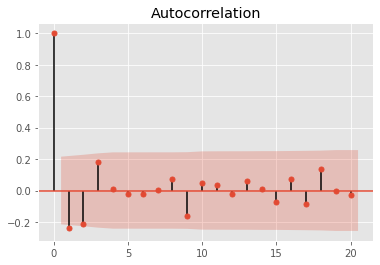

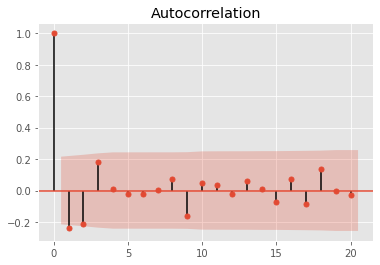

In [ ]:
#The autocorrelation function can tell the order of MA terms, q, needed to remove autocorrelation in the stationary series.

plot_acf(data_italy['mortality'].diff().dropna())

#One lag can be found above the significance level and thus q = 1 or q = 2.

In [ ]:
model_it_try = ARIMA(train_italy['mortality'].dropna(), order=(1, 1, 1))
results_it_try = model_it_try.fit()
results_it_try.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mortality   No. Observations:                   64
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 226.799
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 04 May 2020   AIC                           -445.598
Time:                        23:17:30   BIC                           -436.962
Sample:                    02-01-2020   HQIC                          -442.196
                         - 04-04-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0020      0.001      3.867      0.000       0.001       0.003
ar.L1.D.mortality     0.1887      0.281      0.673      0.504      -0.361       0.739
ma.L1.D.mortality    -0.5358      0.237     -2.261      0.027      -1.000      -0.071
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            5.2987           +0.0000j            5.2987            0.0000
MA.1            1.8663           +0.0000j            1.8663            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model_it = ARIMA(train_italy['mortality'].dropna(), order=(2, 1, 1))
results_it = model_it.fit()
results_it.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mortality   No. Observations:                   64
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 228.099
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 04 May 2020   AIC                           -446.199
Time:                        23:17:30   BIC                           -435.404
Sample:                    02-01-2020   HQIC                          -441.946
                         - 04-04-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0019      0.001      3.555      0.001       0.001       0.003
ar.L1.D.mortality    -0.4129      0.399     -1.034      0.305      -1.196       0.370
ar.L2.D.mortality    -0.3183      0.143     -2.233      0.029      -0.598      -0.039
ma.L1.D.mortality     0.1010      0.425      0.238      0.813      -0.731       0.933
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.6485           -1.6495j            1.7723           -0.3096
AR.2           -0.6485           +1.6495j            1.7723            0.3096
MA.1           -9.9033           +0.0000j            9.9033            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
model_it_try = ARIMA(train_italy['mortality'].dropna(), order=(2, 2, 1))
results_it_try = model_it_try.fit()
results_it_try.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.mortality   No. Observations:                   63
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 222.702
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 04 May 2020   AIC                           -435.404
Time:                        23:17:30   BIC                           -424.688
Sample:                    02-02-2020   HQIC                          -431.189
                         - 04-04-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.604e-05   2.85e-05      1.617      0.111   -9.75e-06       0.000
ar.L1.D2.mortality    -0.3388      0.119     -2.848      0.006      -0.572      -0.106
ar.L2.D2.mortality    -0.3130      0.117     -2.666      0.010      -0.543      -0.083
ma.L1.D2.mortality    -1.0000      0.049    -20.526      0.000      -1.095      -0.905
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5412           -1.7036j            1.7875           -0.2990
AR.2           -0.5412           +1.7036j            1.7875            0.2990
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [ ]:
model_it_try = ARIMA(train_italy['mortality'].dropna(), order=(2, 2, 2))
results_it_try = model_it_try.fit()
results_it_try.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.mortality   No. Observations:                   63
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 222.703
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 04 May 2020   AIC                           -433.406
Time:                        23:17:31   BIC                           -420.547
Sample:                    02-02-2020   HQIC                          -428.348
                         - 04-04-2020                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               4.601e-05   2.86e-05      1.607      0.114   -1.01e-05       0.000
ar.L1.D2.mortality    -0.3560      0.407     -0.875      0.385      -1.154       0.442
ar.L2.D2.mortality    -0.3173      0.151     -2.104      0.040      -0.613      -0.022
ma.L1.D2.mortality    -0.9806      0.441     -2.221      0.030      -1.846      -0.115
ma.L2.D2.mortality    -0.0194      0.439     -0.044      0.965      -0.879       0.841
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5611           -1.6844j            1.7754           -0.3012
AR.2           -0.5611           +1.6844j            1.7754            0.3012
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2          -51.5351           +0.0000j           51.5351            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
model_it_try = ARIMA(train_italy['mortality'].dropna(), order=(1, 1, 2))
results_it_try = model_it_try.fit()
results_it_try.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:            D.mortality   No. Observations:                   64
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 227.679
Method:                       css-mle   S.D. of innovations              0.007
Date:                Mon, 04 May 2020   AIC                           -445.358
Time:                        23:17:31   BIC                           -434.564
Sample:                    02-01-2020   HQIC                          -441.106
                         - 04-04-2020                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0020      0.001      3.891      0.000       0.001       0.003
ar.L1.D.mortality    -0.4471      0.327     -1.368      0.177      -1.088       0.194
ma.L1.D.mortality     0.1535      0.309      0.496      0.621      -0.452       0.759
ma.L2.D.mortality    -0.3185      0.123     -2.591      0.012      -0.559      -0.078
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.2366           +0.0000j            2.2366            0.5000
MA.1           -1.5474           +0.0000j            1.5474            0.5000
MA.2            2.0293           +0.0000j            2.0293            0.0000
-----------------------------------------------------------------------------
"""

Таким образом, лучшая модель для Италии, выбранная по наименьшему AIC - это АРИМА (2, 1, 1). Сделаем с её помощью предсказания для Италии

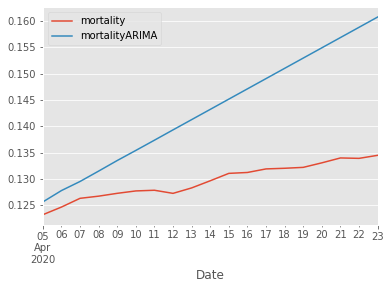

In [ ]:
model_arima_pred_it = results_it.forecast(len(test_italy))[0]
test_italy["mortalityARIMA"] = model_arima_pred_it
test_italy.plot(x="Date", y = ["mortality", "mortalityARIMA"])

In [ ]:
#теперь посчитаем RMSE для выбранной модели ARIMA (2, 1, 1)
model_arima_RMSE_it = RMSE(test_italy.mortalityARIMA, test_italy.mortality)
data_italy_Results.loc[6,"Model"] = "ARIMA"
data_italy_Results.loc[6,"Forecast"] = 'ARIMA (2, 1, 1)'
data_italy_Results.loc[6,"RMSE"] = toFixed(model_arima_RMSE_it, n=5)
data_italy_Results

#нельзя сказать, что модель АРИМА (2, 1, 1) лучшая для Италия среди всех остальных моделей, хотя и предполагалсь, что это будет так. Даже простая линейная модель показывает результат лучше.

Model         Forecast     RMSE
0    Mean          0.04668  0.08300
1  Linear           Linear  0.01273
7      SM               SM  0.00737
8      DO               DO  0.01516
9      TR               TR  0.01466
3      MA               MA  0.01559
4      AR               AR  0.01517
6   ARIMA  ARIMA (2, 1, 1)  0.01552

In [ ]:
#теперь проделаем все те же действия для Испании

#воспользуемся уже написанным выше кодом для напоминания, что временной ряд по Испании, действительно, нестационарный
test = sm.tsa.adfuller(data_spain.mortality.dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

adf:  -0.3443200811001546
p-value:  0.9189885056673741
Critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
Есть единичные корни, ряд не стационарен


In [ ]:
#теперь попробуем взять 1 разницу и посмотрим, стали ли исследуемый ряд стационарным

test = sm.tsa.adfuller(data_spain.mortality.diff().dropna())
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

# p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

#как мы видим, хватает даже одной разницы для превращения нестационарного ряда в стационарный (можно и попробовать взять 2 разницы)

adf:  -2.9374444779647955
p-value:  0.04116377706134384
Critical values:  {'1%': -3.5159766913976376, '5%': -2.898885703483903, '10%': -2.5866935058484217}
Единичных корней нет, ряд стационарен


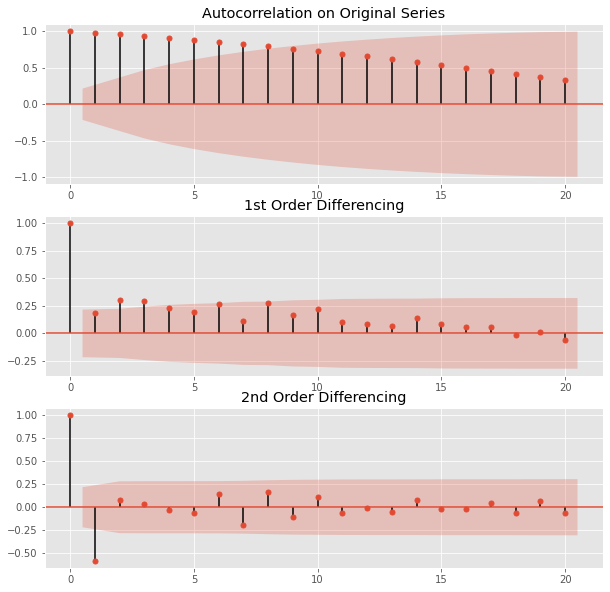

In [ ]:
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(data_spain['mortality'].dropna(), ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(data_spain['mortality'].diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(data_spain['mortality'].diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

#ситуация похожая на Россию, возьмём d=1

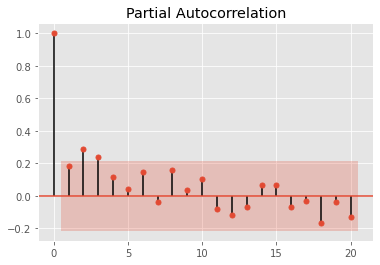

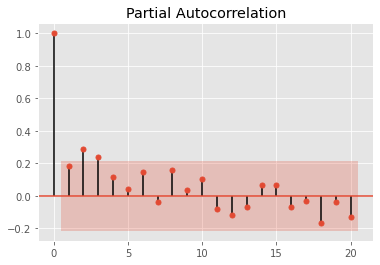

In [ ]:
#Knowing we should difference once, we go on to find out the order of AR, p. We get it by counting the number of lags above the level of significance in partial autocorrelation

plot_pacf(data_spain['mortality'].diff().dropna(), lags=20)

#За нчальное приближение можно взять p = 1, p=2, p=3

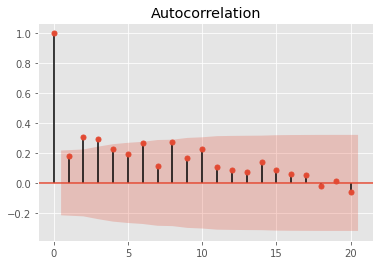

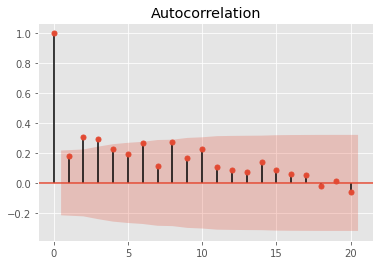

In [ ]:
#The autocorrelation function can tell the order of MA terms, q, needed to remove autocorrelation in the stationary series.

plot_acf(data_spain['mortality'].diff().dropna())

#За начальное приближение можно взять q=1, q=2, q=3

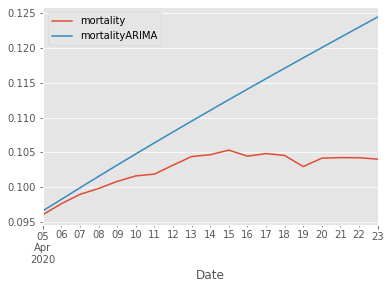

In [ ]:
model_sp = ARIMA(train_spain['mortality'].dropna(), order=(2, 1, 1))
results_sp = model_sp.fit()
model_arima_pred_sp = results_sp.forecast(len(test_spain))[0]
test_spain["mortalityARIMA"] = model_arima_pred_sp
test_spain.plot(x="Date", y = ["mortality", "mortalityARIMA"])

#p = 1 не подходит, поэтому попробуем p = 2

In [ ]:
# RMSE
model_arima_RMSE_sp = RMSE(test_spain.mortalityARIMA, test_spain.mortality)
data_spain_Results.loc[6,"Model"] = "ARIMA"
data_spain_Results.loc[6,"Forecast"] = 'ARIMA (2, 1, 1)'
data_spain_Results.loc[6,"RMSE"] = toFixed(model_arima_RMSE_sp, n = 5)
data_spain_Results

#таким образом, получается, что АРИМА (2, 1, 1) показывает не очень хороший результат, который даже хуже отдельно рассматриваемых MA, AR

Model         Forecast     RMSE
0    Mean          0.02635  0.07618
1  Linear           Linear  0.01162
7      SM               SM  0.00823
8      DO               DO  0.01746
9      TR               TR  0.01799
3      MA               MA  0.00947
4      AR               AR  0.00867
6   ARIMA  ARIMA (2, 1, 1)  0.01054

Таким образом, нельзя однозначно сказать, что АРИМА является лучшей моделью для всех стран из рассматриваемых. Для России, к примеру, удалось подобрать параметры, при которых АРИМА показывает наименьший РМСЕ, а вот для Италии и Испании есть модели, где РМСЕ меньше и намного. 

Посмотрим на модель САРИМА

2.8 SARIMA

САРИМА похожа на АРИМУ только с сезонностью

In [ ]:
#попробуем подобрать параметры для САРИМЫ не с помощью анализа графиков автокорреляции и частичной автокорреляции, а с помощью авто-аримы из пакета pmdarima
from statsmodels.tsa.statespace.sarimax import SARIMAX

!pip install pmdarima
from pmdarima import auto_arima

In [ ]:
import pmdarima as pm

#возьмём m=7, потому что данные дневные, предположим, что есть недельная зависимость (может, тесты делают в одни дни недели, а результаты - в другие, или статистика собирается по определённым дням недели)

# SARIMAX Model для России
sxmodel = pm.auto_arima(train_russia['mortality'].dropna(),
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=-598.642, BIC=-588.427, Time=0.606 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=-595.812, BIC=-591.726, Time=0.067 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=-611.051, BIC=-602.879, Time=0.406 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=-623.751, BIC=-615.579, Time=0.867 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=-597.422, BIC=-595.379, Time=0.046 seconds
Fit ARIMA(0,1,1)x(0,1,0,7) [intercept=True]; AIC=-601.797, BIC=-595.668, Time=0.253 seconds
Fit ARIMA(0,1,1)x(1,1,1,7) [intercept=True]; AIC=-620.810, BIC=-610.595, Time=0.347 seconds
Near non-invertible roots for order (0, 1, 1)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA(0,1,1)x(0,1,2,7) [intercept=True]; AIC=-621.898, BIC=-611.683, Time=2.182 seconds
Fit ARIMA(0,1,1)x(1,1,0,7) [intercept=True]; AIC=-613.850, BIC

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   65
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                 315.876
Date:                           Mon, 04 May 2020   AIC                           -623.751
Time:                                   23:17:49   BIC                           -615.579
Sample:                                        0   HQIC                          -620.575
                                            - 65                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   6.408e-05   2.79e-05      2.295      0.022    9.36e-06       0.000
ma.L1         -0.4920      0.106     -4.640      0.000      -0.700      -0.284
ma.S.L7       -0.8366      0.173     -4.829      0.000      -1.176      -0.497
sigma2      7.668e-07   1.14e-07      6.697      0.000    5.42e-07    9.91e-07
===================================================================================
Ljung-Box (Q):                       26.00   Jarque-Bera (JB):               407.25
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              99.22   Skew:                             3.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

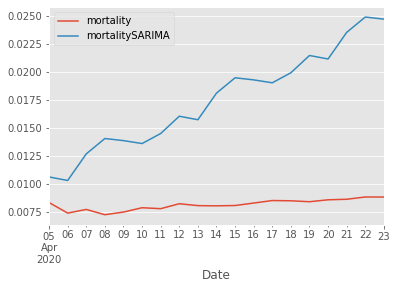

In [ ]:
model_sarima_rus = SARIMAX(train_russia['mortality'].dropna(), order=(0, 1, 1), seasonal_order=(0, 1, 1, 7))
res_sarima_rus = model_sarima_rus.fit()
model_sarima_pred_rus = res_sarima_rus.forecast(len(test_russia))
test_russia["mortalitySARIMA"] = model_sarima_pred_rus
test_russia.plot(x="Date", y = ["mortality", "mortalitySARIMA"])

In [ ]:
# RMSE
model_sarima_RMSE_rus = RMSE(test_russia.mortalitySARIMA, test_russia.mortality)
data_russia_Results.loc[10,"Model"] = "SARIMA"
data_russia_Results.loc[10,"Forecast"] = 'SARIMA'
data_russia_Results.loc[10,"RMSE"] = toFixed(model_sarima_RMSE_rus, n=5)
data_russia_Results

#как мы видим и по графику, и по таблице со значенями RMSE сезонная модель плохо работает для России (вообще это логично, потому что о сезонности чаще говорят, если у нас месячные данные или годовые)

Model         Forecast     RMSE
0     Mean          0.00132  0.00685
1   Linear           Linear  0.00277
7       SM               SM  0.00091
8       DO               DO  0.00676
9       TR               TR  0.00433
3       MA               MA  0.00224
4       AR               AR  0.00225
6    ARIMA  ARIMA (1, 1, 1)  0.00219
10  SARIMA           SARIMA  0.01018

In [ ]:
#повторим все действия для Италии

# SARIMAX Model
sxmodel_it = pm.auto_arima(train_italy['mortality'].dropna(),
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel_it.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=-378.333, BIC=-368.118, Time=0.760 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=-347.134, BIC=-343.048, Time=0.060 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=-362.511, BIC=-354.339, Time=0.410 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=-381.021, BIC=-372.849, Time=1.013 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=-349.103, BIC=-347.060, Time=0.075 seconds
Fit ARIMA(0,1,1)x(0,1,0,7) [intercept=True]; AIC=-351.133, BIC=-345.004, Time=0.205 seconds
Fit ARIMA(0,1,1)x(1,1,1,7) [intercept=True]; AIC=-378.457, BIC=-368.242, Time=0.824 seconds
Fit ARIMA(0,1,1)x(0,1,2,7) [intercept=True]; AIC=-379.704, BIC=-369.489, Time=0.563 seconds
Fit ARIMA(0,1,1)x(1,1,0,7) [intercept=True]; AIC=-365.681, BIC=-357.509, Time=0.482 seconds
Fit ARIMA(0,1,1)x(1,1,2,7) [intercept=True]; AIC=-377.227, BIC=-364.969, Time=1.648 seconds
Fit ARIMA(0,1,0)x(0,1,1,7) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   65
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 7)   Log Likelihood                 195.703
Date:                           Mon, 04 May 2020   AIC                           -381.406
Time:                                   23:17:58   BIC                           -371.191
Sample:                                        0   HQIC                          -377.436
                                            - 65                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.171      0.242      -0.000       0.001
ma.L1         -0.3190      0.246     -1.298      0.194      -0.801       0.163
ma.L2         -0.2797      0.256     -1.094      0.274      -0.781       0.222
ma.S.L7       -0.9613      1.141     -0.842      0.400      -3.198       1.275
sigma2      4.771e-05   5.24e-05      0.910      0.363    -5.5e-05       0.000
===================================================================================
Ljung-Box (Q):                       16.38   Jarque-Bera (JB):               998.38
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.10   Skew:                             3.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        22.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

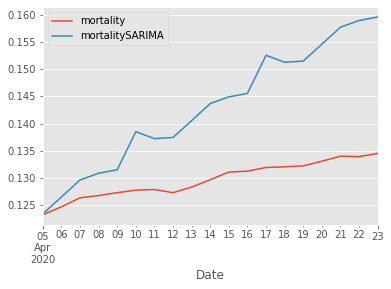

In [ ]:
#используем параметры, подобранные авто-аримой для обучения модели, сделаем предсказания на длину теста и покажем на графике

#при p=0 выводится ошибка сходимости функции максимального правдоподобия, поэтому воспользуемся p=1
model_sarima_it = SARIMAX(train_italy['mortality'].dropna(), order=(1, 1, 2), seasonal_order=(0, 1, 1, 7))
res_sarima_it = model_sarima_it.fit()
model_sarima_pred_it = res_sarima_it.forecast(len(test_italy))
test_italy["mortalitySARIMA"] = model_sarima_pred_it
test_italy.plot(x="Date", y = ["mortality", "mortalitySARIMA"])

In [ ]:
# RMSE
model_sarima_RMSE_it = RMSE(test_italy.mortalitySARIMA, test_italy.mortality)
data_italy_Results.loc[10,"Model"] = "SARIMA"
data_italy_Results.loc[10,"Forecast"] = 'SARIMA'
data_italy_Results.loc[10,"RMSE"] = toFixed(model_sarima_RMSE_it, n=5)
data_italy_Results

#модель получается лучше, чем АРИМА, но незначительно, даже модель линейного тренда работает лучше

Model         Forecast     RMSE
0     Mean          0.04668  0.08300
1   Linear           Linear  0.01273
7       SM               SM  0.00737
8       DO               DO  0.01516
9       TR               TR  0.01466
3       MA               MA  0.01559
4       AR               AR  0.01517
6    ARIMA  ARIMA (2, 1, 1)  0.01552
10  SARIMA           SARIMA  0.01549

In [ ]:
#Теперь проделаем все те же действия для Испании

# SARIMAX Model
sxmodel_sp = pm.auto_arima(train_spain['mortality'].dropna(),
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

sxmodel_sp.summary()

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,1,1,7) [intercept=True]; AIC=-493.162, BIC=-483.035, Time=0.824 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=True]; AIC=-465.682, BIC=-461.631, Time=0.121 seconds
Fit ARIMA(1,1,0)x(1,1,0,7) [intercept=True]; AIC=-482.697, BIC=-474.596, Time=0.252 seconds
Fit ARIMA(0,1,1)x(0,1,1,7) [intercept=True]; AIC=-494.612, BIC=-486.511, Time=0.223 seconds
Fit ARIMA(0,1,0)x(0,1,0,7) [intercept=False]; AIC=-467.456, BIC=-465.431, Time=0.036 seconds
Fit ARIMA(0,1,1)x(0,1,0,7) [intercept=True]; AIC=-464.767, BIC=-458.691, Time=0.095 seconds
Fit ARIMA(0,1,1)x(1,1,1,7) [intercept=True]; AIC=-491.325, BIC=-481.198, Time=0.576 seconds
Fit ARIMA(0,1,1)x(0,1,2,7) [intercept=True]; AIC=-492.736, BIC=-482.609, Time=0.847 seconds
Fit ARIMA(0,1,1)x(1,1,0,7) [intercept=True]; AIC=-482.406, BIC=-474.305, Time=0.461 seconds
Fit ARIMA(0,1,1)x(1,1,2,7) [intercept=True]; AIC=-491.068, BIC=-478.915, Time=1.636 seconds
Fit ARIMA(0,1,0)x(0,1,1,7) [intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 7)   Log Likelihood                 251.438
Date:                           Mon, 04 May 2020   AIC                           -496.875
Time:                                   23:18:10   BIC                           -490.799
Sample:                                        0   HQIC                          -494.520
                                            - 64                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0005      0.000      3.876      0.000       0.000       0.001
ma.S.L7       -0.8779      0.299     -2.935      0.003      -1.464      -0.292
sigma2      6.219e-06      2e-06      3.108      0.002     2.3e-06    1.01e-05
===================================================================================
Ljung-Box (Q):                       18.04   Jarque-Bera (JB):                33.92
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):              24.34   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

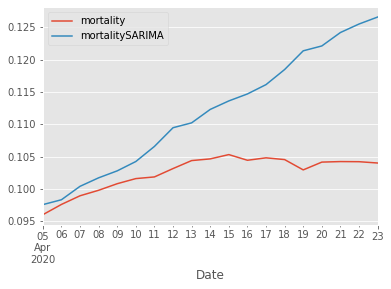

In [ ]:
model_sarima_sp = SARIMAX(train_spain['mortality'].dropna(), order=(0, 1, 0), seasonal_order=(0, 1, 1, 7))
res_sarima_sp = model_sarima_sp.fit()
model_sarima_pred_sp = res_sarima_sp.forecast(len(test_spain))
model_sarima_pred_sp
test_spain["mortalitySARIMA"] = model_sarima_pred_sp
test_spain.plot(x="Date", y = ["mortality", "mortalitySARIMA"])

In [ ]:
# RMSE
model_sarima_RMSE_sp = RMSE(test_spain.mortalitySARIMA, test_spain.mortality)
data_spain_Results.loc[10,"Model"] = "SARIMA"
data_spain_Results.loc[10,"Forecast"] = 'SARIMA'
data_spain_Results.loc[10,"RMSE"] = toFixed(model_sarima_RMSE_sp, n=5)
data_spain_Results

#для Испании САРИМА работает хуже, чем подобранная в предыдущем пункте АРИМА, и хуже, чем большинство моделей

Model         Forecast     RMSE
0     Mean          0.02635  0.07618
1   Linear           Linear  0.01162
7       SM               SM  0.00823
8       DO               DO  0.01746
9       TR               TR  0.01799
3       MA               MA  0.00947
4       AR               AR  0.00867
6    ARIMA  ARIMA (2, 1, 1)  0.01054
10  SARIMA           SARIMA  0.01189

Таким образом, в целом, можно сделать вывод, что САРИМА работает плохо для всех трёх стран. Возможно, что это связано с отсутствием сезонности в данных, которую мы так настойчиво пытались использовать в модели САРИМА

#### 2.9 Библиотека Prophet
Попробуем использовать библиотеку Prophet для предсказания временного ряда. [Документация](https://facebook.github.io/prophet/docs/quick_start.html).


In [ ]:
#для начала необходимо установить и импортировать библиотку Prophet 

!pip install fbprophet
from fbprophet import Prophet


In [ ]:
#как и в прошлых моделях начнём с анализа России

#для работы с библиотекой необходимо привести все данные к одному виду, где ds - это время, а y - данные
df_pro = pd.DataFrame( {'ds': train_russia['Date'],'y': train_russia['mortality']}).reset_index().dropna().drop('Date', axis=1)
model_pro_rus = Prophet()
model_pro_rus.fit(df_pro)
#df_pro_test = pd.DataFrame( {'ds': test_russia['Date'],'y': test_russia['mortality']}).reset_index().dropna().drop('Date', axis=1)
future_rus = model_pro_rus.make_future_dataframe(periods=len(test_russia))
forecast_rus = model_pro_rus.predict(future_rus)
forecast_rus

#как мы видим, в предсказаниях есть не только сами предсказания, но и много других данные таких как тренд, нижние/верхние границы и т.д.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds  trend  ...  multiplicative_terms_upper  yhat
0  2020-01-31  -0.00  ...                        0.00 -0.00
1  2020-02-01  -0.00  ...                        0.00 -0.00
2  2020-02-02  -0.00  ...                        0.00 -0.00
3  2020-02-03  -0.00  ...                        0.00 -0.00
4  2020-02-04  -0.00  ...                        0.00 -0.00
..        ...    ...  ...                         ...   ...
79 2020-04-19   0.01  ...                        0.00  0.01
80 2020-04-20   0.01  ...                        0.00  0.01
81 2020-04-21   0.01  ...                        0.00  0.01
82 2020-04-22   0.01  ...                        0.00  0.01
83 2020-04-23   0.01  ...                        0.00  0.01

[84 rows x 16 columns]

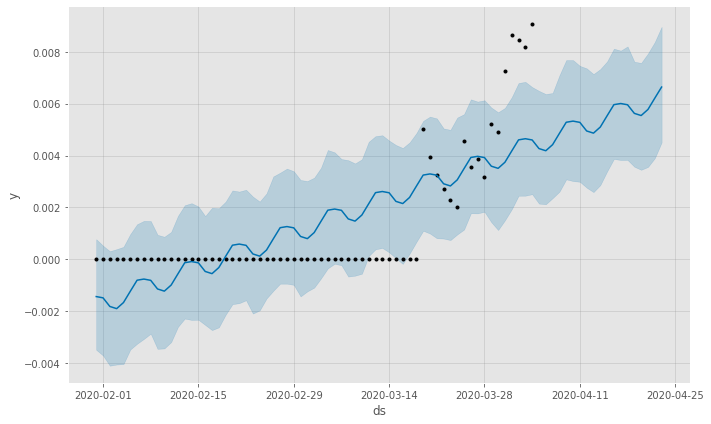

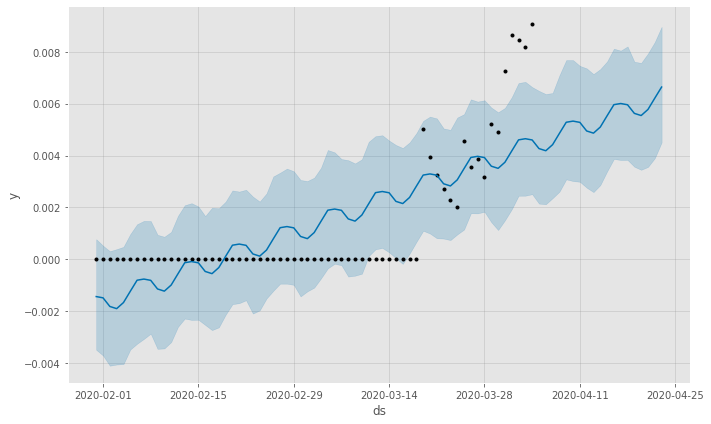

In [ ]:
model_pro_rus.plot(forecast_rus)

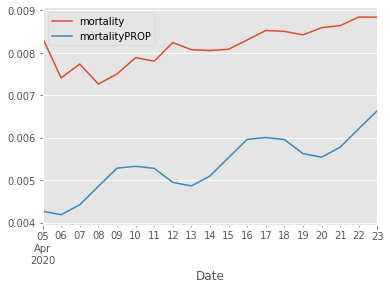

In [ ]:
res_pro_rus = forecast_rus['yhat'][-len(test_russia):]
test_russia["mortalityPROP"] = res_pro_rus.values
test_russia.plot(x="Date", y = ["mortality", "mortalityPROP"])

In [ ]:
# RMSE
model_prop_RMSE_rus = RMSE(test_russia.mortalityPROP, test_russia.mortality)
data_russia_Results.loc[11,"Model"] = "PROPHET"
data_russia_Results.loc[11,"Forecast"] = 'PROPHET'
data_russia_Results.loc[11,"RMSE"] = toFixed(model_prop_RMSE_rus, n=5)
data_russia_Results

#как мы видим, результат один из самых лучших, но, к примеру, подобранная руками для России АРИМА (1, 1, 1) показывает РМСЕ меньше, чем через библиотека Prophet

Model         Forecast     RMSE
0      Mean          0.00132  0.00685
1    Linear           Linear  0.00277
7        SM               SM  0.00091
8        DO               DO  0.00676
9        TR               TR  0.00433
3        MA               MA  0.00224
4        AR               AR  0.00225
6     ARIMA  ARIMA (1, 1, 1)  0.00219
10   SARIMA           SARIMA  0.01018
11  PROPHET          PROPHET  0.00284

In [ ]:
#Теперь проделаем все те же действия для Италии и посмотрим на результат
df_pro_it = pd.DataFrame( {'ds': train_italy['Date'],'y': train_italy['mortality']}).reset_index().dropna().drop('Date', axis=1)
model_pro_it = Prophet()
model_pro_it.fit(df_pro_it)
future_it = model_pro_it.make_future_dataframe(periods=len(test_italy))
forecast_it = model_pro_it.predict(future_it)
forecast_it

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds  trend  ...  multiplicative_terms_upper  yhat
0  2020-01-31  -0.01  ...                        0.00 -0.01
1  2020-02-01  -0.01  ...                        0.00 -0.01
2  2020-02-02  -0.01  ...                        0.00 -0.01
3  2020-02-03  -0.01  ...                        0.00 -0.01
4  2020-02-04  -0.01  ...                        0.00 -0.01
..        ...    ...  ...                         ...   ...
79 2020-04-19   0.17  ...                        0.00  0.17
80 2020-04-20   0.17  ...                        0.00  0.17
81 2020-04-21   0.17  ...                        0.00  0.17
82 2020-04-22   0.18  ...                        0.00  0.18
83 2020-04-23   0.18  ...                        0.00  0.18

[84 rows x 16 columns]

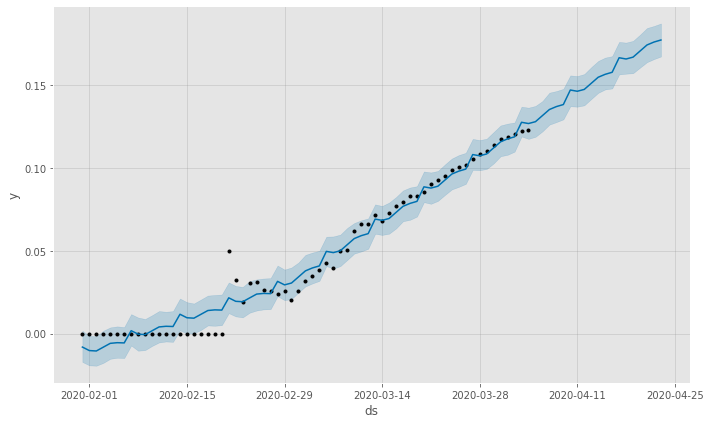

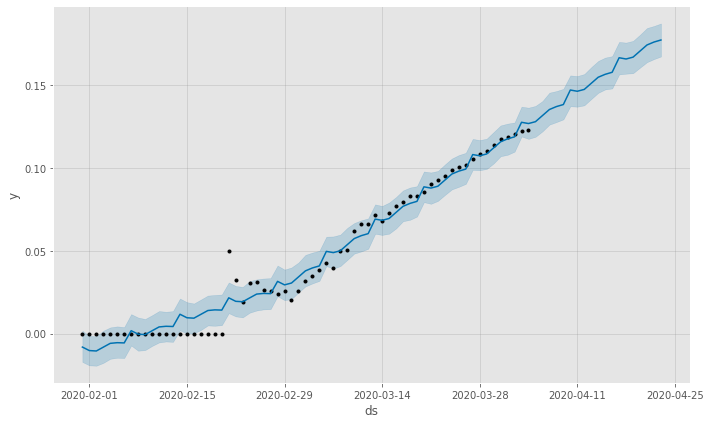

In [ ]:
model_pro_it.plot(forecast_it)

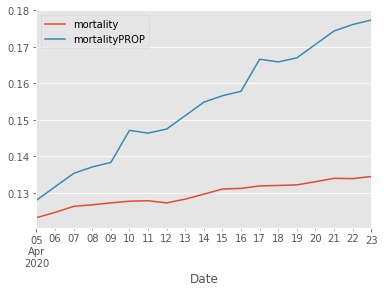

In [ ]:
res_pro_it = forecast_it['yhat'][-len(test_italy):]
test_italy["mortalityPROP"] = res_pro_it.values
test_italy.plot(x="Date", y = ["mortality", "mortalityPROP"])

In [ ]:
# RMSE
model_prop_RMSE_it = RMSE(test_italy.mortalityPROP, test_italy.mortality)
data_italy_Results.loc[11,"Model"] = "PROPHET"
data_italy_Results.loc[11,"Forecast"] = 'PROPHET'
data_italy_Results.loc[11,"RMSE"] = toFixed(model_prop_RMSE_it, n=5)
data_italy_Results

#результат РМСЕ, полученный с помощью библиотки Prophet хуже, чем многие другие модели

Model         Forecast     RMSE
0      Mean          0.04668  0.08300
1    Linear           Linear  0.01273
7        SM               SM  0.00737
8        DO               DO  0.01516
9        TR               TR  0.01466
3        MA               MA  0.01559
4        AR               AR  0.01517
6     ARIMA  ARIMA (2, 1, 1)  0.01552
10   SARIMA           SARIMA  0.01549
11  PROPHET          PROPHET  0.02736

In [ ]:
#повторим действия для Испании
df_pro_sp = pd.DataFrame( {'ds': train_spain['Date'],'y': train_spain['mortality']}).reset_index().dropna().drop('Date', axis=1)
model_pro_sp = Prophet()
model_pro_sp.fit(df_pro_sp)
future_sp = model_pro_sp.make_future_dataframe(periods=len(test_spain))
forecast_sp = model_pro_sp.predict(future_sp)
forecast_sp

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds  trend  ...  multiplicative_terms_upper  yhat
0  2020-02-01  -0.00  ...                        0.00 -0.00
1  2020-02-02  -0.00  ...                        0.00  0.00
2  2020-02-03  -0.00  ...                        0.00 -0.00
3  2020-02-04  -0.00  ...                        0.00 -0.00
4  2020-02-05  -0.00  ...                        0.00 -0.00
..        ...    ...  ...                         ...   ...
78 2020-04-19   0.15  ...                        0.00  0.15
79 2020-04-20   0.15  ...                        0.00  0.15
80 2020-04-21   0.16  ...                        0.00  0.16
81 2020-04-22   0.16  ...                        0.00  0.16
82 2020-04-23   0.16  ...                        0.00  0.16

[83 rows x 16 columns]

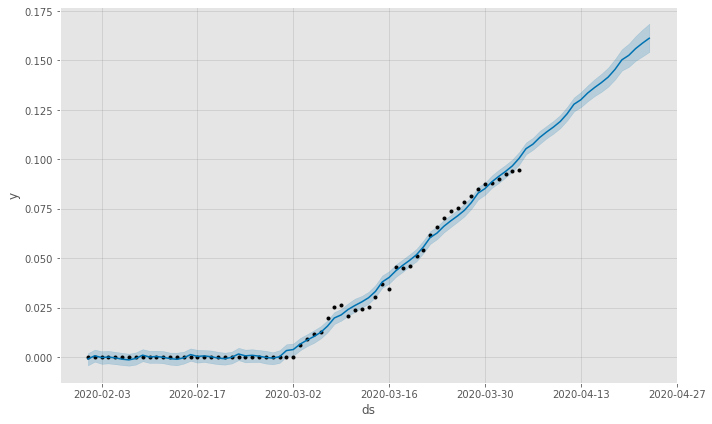

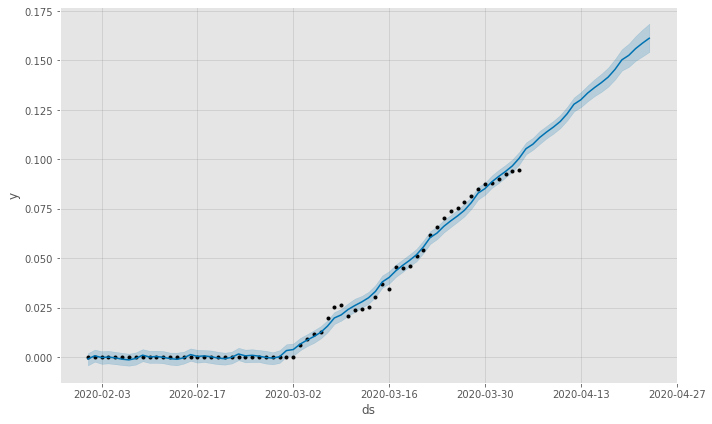

In [ ]:
model_pro_sp.plot(forecast_sp)

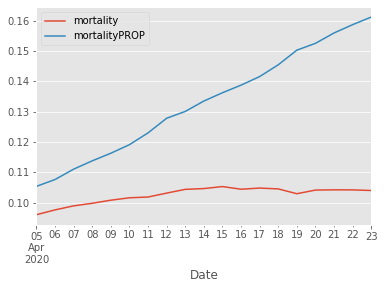

In [ ]:
res_pro_sp = forecast_sp['yhat'][-len(test_spain):]
test_spain["mortalityPROP"] = res_pro_sp.values
test_spain.plot(x="Date", y = ["mortality", "mortalityPROP"])

In [ ]:
# RMSE
model_prop_RMSE_sp = RMSE(test_spain.mortalityPROP, test_spain.mortality)
model_prop_RMSE_sp
data_spain_Results.loc[11,"Model"] = "PROPHET"
data_spain_Results.loc[11,"Forecast"] = 'PROPHET'
data_spain_Results.loc[11,"RMSE"] = toFixed(model_prop_RMSE_sp, n=5)
data_spain_Results

#как и в случае с Италией РМСЕ получается высоким относительно результатов других моделей

Model         Forecast     RMSE
0      Mean          0.02635  0.07618
1    Linear           Linear  0.01162
7        SM               SM  0.00823
8        DO               DO  0.01746
9        TR               TR  0.01799
3        MA               MA  0.00947
4        AR               AR  0.00867
6     ARIMA  ARIMA (2, 1, 1)  0.01054
10   SARIMA           SARIMA  0.01189
11  PROPHET          PROPHET  0.03426

Таким образом, модель из библиотеки Prophet работает в основном хуже, чем те, что подбираются руками.

#### 2.10 Линейная модель с регрессией (Linear Regression Model)

Какие признаки оказались наиболее значимыми?

Для построения этой модели логичнее будет воспользоваться общей выборкой по трём странам, потому что если смотреть на разные признаки, которые выбраны в 1 части относительно одной страны, то они будут константные и дадут никакой пользы. Если соединить выборку, построить линейную модель с регрессией со всеми выделенными признаками, то можно делать прогнозы для каждоый страны в отдельности и при этом понять, какие признаки наиболее значимые, что и требуется сделать в задании. Для начала соединим выборку из трёх стран.

In [ ]:
data_train = pd.concat([train_russia,train_spain, train_italy], ignore_index=True)
data_test = pd.concat([test_russia, test_spain, test_italy], ignore_index=True)

#перепишем название некоторых признаков на более удобные в построении модели с регрессией
data_train.head()
data_train.rename(columns={'Country/Region': 'country', 'Density (P/Km²)': 'density', 'Med. Age': 'age', 'Migrants (net)': 'migrants', 'Population (2020)': 'pop'}, inplace=True)

#заметим, что некоторые признаки категориальные, поэтому закодируем их с помощью LabelEncoder
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(data_train.country)
data_train['country_le'] = le.transform(data_train.country)

#data_train.rename(columns={'Country/Region': 'country', 'Density (P/Km²)': 'density', 'Urban Pop %': 'urban', 'Med. Age': 'age', 'Migrants (net)': 'migrants', 'Population (2020)': 'pop'}, inplace=True)

data_test.head()

data_test.rename(columns={'Country/Region': 'country', 'Density (P/Km²)': 'density', 'Urban Pop %': 'urban', 'Med. Age': 'age', 'Migrants (net)': 'migrants', 'Population (2020)': 'pop'}, inplace=True)
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
le.fit(data_test.country)
data_test['country_le'] = le.transform(data_test.country)

#data_test.rename(columns={'Country/Region': 'country', 'Density (P/Km²)': 'density', 'Urban Pop %': 'urban', 'Med. Age': 'age', 'Migrants (net)': 'migrants', 'Population (2020)': 'pop'}, inplace=True)

In [ ]:
## Построим линейную регрессию, используя несколько переменных: индекс времени, месяц, численность, плотность, мигранты, средний возраст, число дней с 1 случая заражения, страна
model_linear_reg= smf.ols('mortality ~ timeIndex + month + pop + density	+ migrants + age + nums + C(country)', data = data_train).fit()

In [ ]:
model_linear_reg.summary()

#значимыми признаками являются индекс времени, численность, мигранты, число дней с 1 случая
#регрессия является адекватной, потому что F-статистика меньше 0.05
#R2 0.708, что является хорошим показателем

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              mortality   R-squared:                       0.708
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 04 May 2020   Prob (F-statistic):           1.75e-49
Time:                        23:18:25   Log-Likelihood:                 487.95
No. Observations:                 194   AIC:                            -965.9
Df Residuals:                     189   BIC:                            -949.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             -9.55e-08   2.94e-07     -0.325      0.746   -6.76e-07    4.85e-07
age[T.45]            -1.155e-07   3.56e-07     -0.325      0.746   -8.17e-07    5.86e-07
age[T.47]            -2.907e-08   8.95e-08     -0.325      0.746   -2.06e-07    1.48e-07
C(country)[T.Russia]  4.905e-08   1.51e-07      0.325      0.746   -2.49e-07    3.47e-07
C(country)[T.Spain]  -1.155e-07   3.56e-07     -0.325      0.746   -8.17e-07    5.86e-07
timeIndex                0.0006   8.21e-05      7.766      0.000       0.000       0.001
month                    0.0006      0.005      0.128      0.899      -0.009       0.010
pop                  -6.822e-10   1.49e-10     -4.590      0.000   -9.75e-10   -3.89e-10
density               -1.64e-05   5.05e-05     -0.325      0.746      -0.000    8.32e-05
migrants              2.895e-07   8.45e-08      3.426      0.001    1.23e-07    4.56e-07
nums                     0.0006   8.03e-05      7.957      0.000       0.000       0.001
==============================================================================
Omnibus:                       46.811   Durbin-Watson:                   0.101
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.406
Skew:                           0.262   Prob(JB):                      0.00334
Kurtosis:                       1.934   Cond. No.                     8.51e+27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.43e-38. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

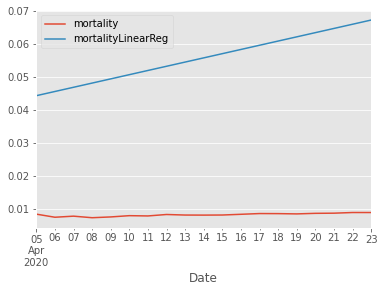

In [ ]:
#сделаем предсказания по России

model_linear_reg_rus = model_linear_reg.predict(data_test[data_test['country']=='Russia'])
test_russia["mortalityLinearReg"] = list(model_linear_reg_rus)
test_russia.plot(kind="line", x="Date", y = ["mortality", "mortalityLinearReg"])

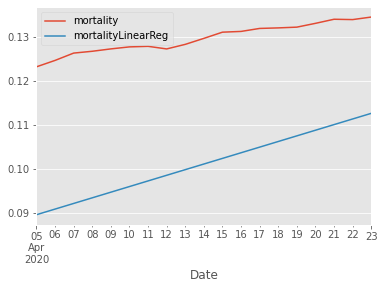

In [ ]:
#Италия

model_linear_reg_it = model_linear_reg.predict(data_test[data_test['country']=='Italy'])
test_italy["mortalityLinearReg"] = list(model_linear_reg_it)
test_italy.plot(kind="line", x="Date", y = ["mortality", "mortalityLinearReg"])

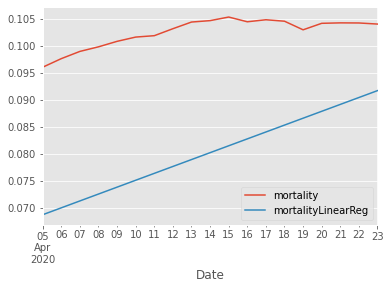

In [ ]:
#Испания

model_linear_reg_sp = model_linear_reg.predict(data_test[data_test['country']=='Spain'])
test_spain["mortalityLinearReg"] = list(model_linear_reg_sp)
test_spain.plot(kind="line", x="Date", y = ["mortality", "mortalityLinearReg"])

In [ ]:
model_linear_reg_RMSE_rus = RMSE(test_russia.mortalityLinearReg, test_russia.mortality)
model_linear_reg_RMSE_rus

model_linear_reg_RMSE_it = RMSE(test_italy.mortalityLinearReg, test_italy.mortality)
model_linear_reg_RMSE_it

model_linear_reg_RMSE_sp = RMSE(test_spain.mortalityLinearReg, test_spain.mortality)
model_linear_reg_RMSE_sp

0.022872816910969727

In [ ]:
data_russia_Results.loc[2,"Model"] = "LinearReg"
data_russia_Results.loc[2,"Forecast"] = 'LinearReg'
data_russia_Results.loc[2,"RMSE"] = toFixed(model_linear_reg_RMSE_rus, n=5)
print(data_russia_Results.head())

data_italy_Results.loc[2,"Model"] = "LinearReg"
data_italy_Results.loc[2,"Forecast"] = 'LinearReg'
data_italy_Results.loc[2,"RMSE"] = toFixed(model_linear_reg_RMSE_it, n=5)
print(data_italy_Results.head())

data_spain_Results.loc[2,"Model"] = "LinearReg"
data_spain_Results.loc[2,"Forecast"] = 'LinearReg'
data_spain_Results.loc[2,"RMSE"] = toFixed(model_linear_reg_RMSE_sp, n=5)
print(data_spain_Results)

    Model Forecast     RMSE
0    Mean  0.00132  0.00685
1  Linear   Linear  0.00277
7      SM       SM  0.00091
8      DO       DO  0.00676
9      TR       TR  0.00433
    Model Forecast     RMSE
0    Mean  0.04668  0.08300
1  Linear   Linear  0.01273
7      SM       SM  0.00737
8      DO       DO  0.01516
9      TR       TR  0.01466
        Model         Forecast     RMSE
0        Mean          0.02635  0.07618
1      Linear           Linear  0.01162
7          SM               SM  0.00823
8          DO               DO  0.01746
9          TR               TR  0.01799
3          MA               MA  0.00947
4          AR               AR  0.00867
6       ARIMA  ARIMA (2, 1, 1)  0.01054
10     SARIMA           SARIMA  0.01189
11    PROPHET          PROPHET  0.03426
2   LinearReg        LinearReg  0.02287


In [ ]:
data_russia_Results

#таким образом, по линейной модели с регрессией нельзя сказать, что она хорошо работает, суда по значению РМСЕ
#возможно, потому что в ней был сделан акцент в основном не на временные особенности данных, а на другие признаки, поэтому она и не даёт хороших результатов

Model         Forecast     RMSE
0        Mean          0.00132  0.00685
1      Linear           Linear  0.00277
7          SM               SM  0.00091
8          DO               DO  0.00676
9          TR               TR  0.00433
3          MA               MA  0.00224
4          AR               AR  0.00225
6       ARIMA  ARIMA (1, 1, 1)  0.00219
10     SARIMA           SARIMA  0.01018
11    PROPHET          PROPHET  0.00284
2   LinearReg        LinearReg  0.04811

In [ ]:
data_italy_Results

#вывод как и в случае с Россией

Model         Forecast     RMSE
0        Mean          0.04668  0.08300
1      Linear           Linear  0.01273
7          SM               SM  0.00737
8          DO               DO  0.01516
9          TR               TR  0.01466
3          MA               MA  0.01559
4          AR               AR  0.01517
6       ARIMA  ARIMA (2, 1, 1)  0.01552
10     SARIMA           SARIMA  0.01549
11    PROPHET          PROPHET  0.02736
2   LinearReg        LinearReg  0.02870

In [ ]:
data_spain_Results

#такой же вывод как и в случаях двух предыдущих стран.

Model         Forecast     RMSE
0        Mean          0.02635  0.07618
1      Linear           Linear  0.01162
7          SM               SM  0.00823
8          DO               DO  0.01746
9          TR               TR  0.01799
3          MA               MA  0.00947
4          AR               AR  0.00867
6       ARIMA  ARIMA (2, 1, 1)  0.01054
10     SARIMA           SARIMA  0.01189
11    PROPHET          PROPHET  0.03426
2   LinearReg        LinearReg  0.02287

Таком образом, что касается линейной модели с регрессией, то она помогает выделить важные признаки, если анализировать общую выборку и делать конкретный прогноз для страны, но при этом РМСЕ в сравнении с моделями, которые анализируют страны в отдельности и делают акцент на временных особенностях, работают лучше.

2.11 Попробуем использовтаь xgboost для предсказания.


In [ ]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = data_train['timeIndex'].dropna(), data_test['timeIndex'].dropna(), data_train['mortality'].dropna().values, data_test['mortality'].dropna().values
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

In [ ]:
#XGB_forecast(data_test['timeIndex'].dropna(), lag_start=5, lag_end=30)

#### 2.11 Выводы

Таким образом, по 2 части можно сделать следующие выводы: для всех стран хорошо работает экспоненциальное сглаживание, однако затем результаты рознятся. Для России хорошо работают модели АР, МА, АРИМА. Для Италии те, которые связаны с трендом (модель с линейным трендом, модели сглаживания). А для Испании, как и для России, модели АР, МА и АРИМА. Мне кажется, что возможно, сложилась такая ситуация, потому что в Италии тренд более ярко выражен, чем в России и Испании, поэтому и модели с трендом работают на данных этой страны лучше. Ещё одну вещь, которую хотелось бы отметить в выводе по 2 части - это необходимость в моделях АРИМА бороться с нестационарностью рядов, которая была общей для всех трёх стран.

In [ ]:
data_russia_Results.sort_values(by='RMSE')

Model         Forecast     RMSE
7          SM               SM  0.00091
6       ARIMA  ARIMA (1, 1, 1)  0.00219
3          MA               MA  0.00224
4          AR               AR  0.00225
1      Linear           Linear  0.00277
11    PROPHET          PROPHET  0.00284
9          TR               TR  0.00433
8          DO               DO  0.00676
0        Mean          0.00132  0.00685
10     SARIMA           SARIMA  0.01018
2   LinearReg        LinearReg  0.04811

In [ ]:
data_italy_Results.sort_values(by='RMSE')

Model         Forecast     RMSE
7          SM               SM  0.00737
1      Linear           Linear  0.01273
9          TR               TR  0.01466
8          DO               DO  0.01516
4          AR               AR  0.01517
10     SARIMA           SARIMA  0.01549
6       ARIMA  ARIMA (2, 1, 1)  0.01552
3          MA               MA  0.01559
11    PROPHET          PROPHET  0.02736
2   LinearReg        LinearReg  0.02870
0        Mean          0.04668  0.08300

In [ ]:
data_spain_Results.sort_values(by='RMSE')

Model         Forecast     RMSE
7          SM               SM  0.00823
4          AR               AR  0.00867
3          MA               MA  0.00947
6       ARIMA  ARIMA (2, 1, 1)  0.01054
1      Linear           Linear  0.01162
10     SARIMA           SARIMA  0.01189
8          DO               DO  0.01746
9          TR               TR  0.01799
2   LinearReg        LinearReg  0.02287
11    PROPHET          PROPHET  0.03426
0        Mean          0.02635  0.07618

## Выводы по работе
Что касается общего вывода, то необходимо сказать, что несмотря на внешнюю схожесть развития болезни по миру при анализе трёх стран в отдельности более близко выясняется, что им подходят разные модели, точнее, лучше работают. Конечно, визуализация и корреляции помогают увидеть общие закономерности, но, чтобы более качественно спрогнозировать дату необходимо внимательно анализировать одну страну, пробуя разные модели и, главное, гиперпараметры. Интересной особенностью данных в дз была нестационарность, вызванная, скороее всего, характерным трендом. С ней нужно было бороться, что иметь право анализировать модели АРИМА. Что касается других моделей, то проблем с ними не возникло. 